## FDL- DSBA Assignment 2022-2023

### Please fill the blanks in the code and answer to the questions that are asked in the Jupyter Notebook ("Markdown" cell). 

### Instructions: Rename the jupyter adding your name at the end of the title FDL_Assignment-<YOUR NAME\>.ipynb

### Send your solution to fdl.dsba@gmail.com by X / X / X, as subject for the mail please put FDL_Assignment-<YOUR NAME\>

## Question 1 -  TRAIN ON CIFAR DATASET
In this exercise you are asked to train a Convolutional Neural Network (CNN) on the CIFAR10 dataset and visualize its feature maps.

### 1a) Download the CIFAR10 dataset using the already provided PyTorch dataloaders. 
*   Read and understand the following code
*   Feel free to add additional transformations of data. Explain if so. 

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchvision
from tqdm import tqdm
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive

drive = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json 
from pprint import pprint
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(12, 6), dpi=100)

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:

# *****START CODE 
##Here you are free to add further transform functions if you wish
print('==> Preparing data..')
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))])

batch_size=64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size , shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
val_dataloader = torch.utils.data.DataLoader(testset, batch_size= batch_size, shuffle=False)
# *****END CODE

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


### 1b) Create your convolutional neural network.
*   Go to https://dljudge.io/generate + /<YOUR NAME\> or use curl below
*   Save the page as json 
*   Build your CNN architecture based on those modules and hyperparameters
*   Use the right value for 'COMPUTE' 
*   See the example below

In [ ]:
# !curl https://dljudge.io/generate/ArindamRoy -o network1.json

In [ ]:
import matplotlib.pyplot as plt

def accuracy(preds, labels):
    return (labels==preds.cpu()).sum()/len(labels) # Argmax of logits is the argmax of the predictions (the softmax of the logits)


def precision(cm):
    return [round(col[i]/col.sum(),4) for i, col in enumerate(cm.T)]


def recall(cm):
    return [round(row[i]/row.sum(),4) for i, row in enumerate(cm)]
    
def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('{}/chart.png'.format(save_folder))

def write_results(save_folder, epoch, train_acc, val_acc, train_loss, val_loss):
    with open('./{}/progress.txt'.format(save_folder),'a') as ff:
      ff.write(' E: ')
      ff.write(str(epoch))
      ff.write('         ')
      ff.write(' TRAIN_OA: ')
      ff.write(str('%.3f' % train_acc))
      ff.write(' VAL_OA: ')
      ff.write(str('%.3f' % val_acc))
      ff.write('         ')
      ff.write(' TRAIN_LOSS: ')
      ff.write(str('%.3f' % train_loss))
      ff.write(' VAL_LOSS: ')
      ff.write(str('%.3f' % val_loss))
      ff.write('\n')

In [ ]:
def validate_network(model, input_dict):
    """
    Validate if your network definition is same as provided archtiecture
    """
    output = {}
    i = 1
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            output[f'Layer_{str(i).zfill(3)}'] = {'type': 'Conv2d',
                                                  'kernel_size': layer.kernel_size[0],
                                                   'input': layer.in_channels,
                                                   'output': layer.out_channels,
                                                   'padding': layer.padding[0]}

        if isinstance(layer, nn.ReLU):
            output[f'Layer_{str(i).zfill(3)}'] = {'type': 'ReLU'}

        if isinstance(layer, nn.MaxPool2d):
            output[f'Layer_{str(i).zfill(3)}'] = {'type': 'MaxPool2d',
                                                  'kernel_size': layer.kernel_size,
                                                  'stride': layer.stride}

        if isinstance(layer, nn.AdaptiveAvgPool2d):
            output[f'Layer_{str(i).zfill(3)}'] = {'type': 'AdaptiveAvgPool2d',
                                                  'output': layer.output_size}

        if isinstance(layer, nn.BatchNorm2d):
            output[f'Layer_{str(i).zfill(3)}'] = {'type': 'BatchNorm2d',
                                                  'input': layer.num_features}

        if isinstance(layer, nn.Dropout):
            output[f'Layer_{str(i).zfill(3)}'] = {'type': 'Dropout',
                                                  'p': layer.p}

        if isinstance(layer, nn.Linear):
            output[f'Layer_{str(i).zfill(3)}'] = {'type': 'Linear',
                                                  'input': layer.in_features,
                                                  'output': layer.out_features}

        i += 1

    
    correct = True
    for l in output.keys():
        if l in input_dict:
            inp_kvs = input_dict[l]
            out_kvs = output[l]
            for k in out_kvs:
                if inp_kvs[k] != 'COMPUTE':
                    if out_kvs[k] != inp_kvs[k]:
                        print (f'Error in {l}, {k}!')
                        correct = False

    if correct:
        print ('OK!')

In [ ]:
# *****START CODE 
# Import your individual architecture dictionnary here
fin = open('/content/nn_arindam_roy.json', 'r')
my_architecture_dict = json.load(fin)
fin.close()
pprint(my_architecture_dict)
# *****END CODE

{'Layer_001': {'input': 3,
               'kernel_size': 3,
               'output': 60,
               'padding': 1,
               'type': 'Conv2d'},
 'Layer_002': {'type': 'ReLU'},
 'Layer_003': {'input': 60,
               'kernel_size': 3,
               'output': 60,
               'padding': 1,
               'type': 'Conv2d'},
 'Layer_004': {'type': 'ReLU'},
 'Layer_005': {'kernel_size': 2, 'stride': 2, 'type': 'MaxPool2d'},
 'Layer_006': {'input': 60,
               'kernel_size': 3,
               'output': 134,
               'padding': 1,
               'type': 'Conv2d'},
 'Layer_007': {'type': 'ReLU'},
 'Layer_008': {'input': 134,
               'kernel_size': 3,
               'output': 134,
               'padding': 1,
               'type': 'Conv2d'},
 'Layer_009': {'type': 'ReLU'},
 'Layer_010': {'kernel_size': 2, 'stride': 2, 'type': 'MaxPool2d'},
 'Layer_011': {'input': 134,
               'kernel_size': 3,
               'output': 259,
               'padding': 1,
 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# *****START CODE
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        """
        Number of layers should be exactly same as in the provided JSON. 
        Do not use any grouping function like Sequential 
        """
        self.l1conv = nn.Conv2d(in_channels=3, 
                            out_channels=60,
                            padding=1,
                            kernel_size=3)
        self.l2relu = nn.ReLU()
        self.l3conv = nn.Conv2d(in_channels=60, 
                            out_channels=60,
                            padding=1,
                            kernel_size=3)
        self.l4relu = nn.ReLU()
        self.l5maxpool = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.l6conv = nn.Conv2d(in_channels=60, 
                            out_channels=134,
                            padding=1,
                            kernel_size=3)
        self.l7relu = nn.ReLU()
        self.l8conv = nn.Conv2d(in_channels=134, 
                            out_channels=134,
                            padding=1,
                            kernel_size=3)   
        self.l9relu = nn.ReLU()
        self.l10maxpool = nn.MaxPool2d(kernel_size = 2, stride=2)     
        self.l11conv = nn.Conv2d(in_channels=134, 
                            out_channels=259,
                            padding=1,
                            kernel_size=3) 
        self.l12relu = nn.ReLU()
        self.l13conv = nn.Conv2d(in_channels=259, 
                            out_channels=259,
                            padding=1,
                            kernel_size=3) 
        self.l14relu = nn.ReLU()
        self.l15conv = nn.Conv2d(in_channels=259, 
                            out_channels=259,
                            padding=1,
                            kernel_size=3) 
        self.l16relu = nn.ReLU()
        self.l17maxpool = nn.MaxPool2d(kernel_size = 2, stride=2)       
        self.l18conv = nn.Conv2d(in_channels=259, 
                            out_channels=500,
                            padding=1,
                            kernel_size=3)   
        self.l19relu = nn.ReLU()
         
        self.l20conv = nn.Conv2d(in_channels=500, 
                            out_channels=500,
                            padding=1,
                            kernel_size=3)   
        self.l21relu = nn.ReLU()
        
        self.l22conv = nn.Conv2d(in_channels=500, 
                            out_channels=500,
                            padding=1,
                            kernel_size=3)   
        self.l23relu = nn.ReLU()
        self.l24maxpool = nn.MaxPool2d(kernel_size = 2, stride=2) 
        self.l25conv = nn.Conv2d(in_channels=500, 
                            out_channels=500,
                            padding=1,
                            kernel_size=3)  
        self.l26relu = nn.ReLU()
        self.l27conv = nn.Conv2d(in_channels=500, 
                            out_channels=500,
                            padding=1,
                            kernel_size=3)   
        self.l28relu = nn.ReLU()

        self.l29conv = nn.Conv2d(in_channels=500, 
                            out_channels=500,
                            padding=1,
                            kernel_size=3)   
        self.l30relu = nn.ReLU()
        self.l31max_pool2d = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.l32adaptive_avg_pool2d = nn.AvgPool2d((1,1))
        self.l33dropout = nn.Dropout(p = 0.4841825499261502)
        self.l34linear = nn.Linear(500*1*1,2409)
        self.l35relu = nn.ReLU()
        self.l36linear = nn.Linear(2409,10)
    def forward(self, x):
        # l1
        x = self.l1conv(x)
        # l2
        x = self.l2relu(x)
        # l3
        x = self.l3conv(x)
        # l4
        x = self.l4relu(x)
        # l5
        x = self.l5maxpool(x)
        # l6 
        x = self.l6conv(x)
        # l7
        x = self.l7relu(x)
        # l8
        x = self.l8conv(x)
        # l9
        x = self.l9relu(x)
        # l10
        x = self.l10maxpool(x)
        # l11
        x = self.l11conv(x)
        # l12
        x = self.l12relu(x)
        # l13
        x = self.l13conv(x)
        # l14
        x = self.l14relu(x)
        # l15
        x = self.l15conv(x)
        # l16
        x = self.l16relu(x)
        # l17
        x = self.l17maxpool(x)
        # l18
        x = self.l18conv(x)
        # l19
        x = self.l19relu(x)
        # l20
        x = self.l20conv(x)
        # l21
        x = self.l21relu(x)
        # l22
        x = self.l22conv(x)
        # l23
        x = self.l23relu(x)
        # l24
        x = self.l24maxpool(x)
        # l25
        x = self.l25conv(x)
        # l26
        x = self.l26relu(x)
        # l27
        x = self.l27conv(x)
        # l28
        x = self.l28relu(x)
        # l29
        x = self.l29conv(x)
        # l30
        x = self.l30relu(x)
        # l31
        x = self.l31max_pool2d(x)
        # l32
        x = self.l32adaptive_avg_pool2d(x)
        # l33
        x = self.l33dropout(x)
        x = x.reshape(x.size(0), -1)
        # l34
        x = self.l34linear(x)
        # l35
        x = self.l35relu(x)
        # l36
        x = self.l36linear(x)
        return x
# *****END CODE

### 1c) Create the training scheme
*    Initialize the model
*    Validate the model
*    Specify the training hyperparameters like type of optimizer, criterion and learning rate
*    Specify number of epochs
*    Connect the model and any further informations to WandB

Then train the model, doing one evaluation pass per epoch (make sure to log any interesting metric to WandB during training).

In [ ]:
!pip install torchnet
import torchnet as tnt
confusion_matrix = tnt.meter.ConfusionMeter(10)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
save_folder = 'drive/MyDrive/FDL'

In [ ]:

import torch.optim as optim
model = ConvNet().to(device)
validate_network(model, my_architecture_dict)
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 20


OK!


EPOCH NUMBER: 1


  0%|          | 0/782 [00:00<?, ?it/s]

Train (epoch 1/20) [0/782 (0%)]	Loss: 2.304618


 13%|█▎        | 104/782 [00:06<00:45, 14.88it/s]

Train (epoch 1/20) [100/782 (13%)]	Loss: 2.299997


 26%|██▌       | 204/782 [00:13<00:39, 14.75it/s]

Train (epoch 1/20) [200/782 (26%)]	Loss: 2.041445


 39%|███▊      | 302/782 [00:22<00:51,  9.30it/s]

Train (epoch 1/20) [300/782 (38%)]	Loss: 1.900366


 51%|█████▏    | 402/782 [00:32<00:39,  9.74it/s]

Train (epoch 1/20) [400/782 (51%)]	Loss: 1.971838


 64%|██████▍   | 503/782 [00:40<00:22, 12.33it/s]

Train (epoch 1/20) [500/782 (64%)]	Loss: 1.774313


 77%|███████▋  | 603/782 [00:46<00:09, 18.79it/s]

Train (epoch 1/20) [600/782 (77%)]	Loss: 1.681178


 90%|████████▉ | 703/782 [00:51<00:04, 18.62it/s]

Train (epoch 1/20) [700/782 (90%)]	Loss: 1.948785


100%|██████████| 157/157 [00:05<00:00, 26.60it/s]


Confusion Matrix:
[[  0   0  10  21   0  39   0  33 651 246]
 [  0   0  21  27   0  31   0   9 675 237]
 [  0   0  25  57   0 634   0  71  53 160]
 [  0   0  23  64   0 672   0 105  32 104]
 [  0   0  15  39   0 759   0  79  21  87]
 [  0   0  15  57   0 771   0  66  24  67]
 [  0   0  12  33   0 815   0  84   6  50]
 [  0   0  13  47   0 455   0 352  21 112]
 [  0   0   7  16   0  15   0  11 782 169]
 [  0   0  10  37   0  67   0  66 440 380]]
TRAIN_LOSS:  2.011 TRAIN_ACC:  19.024
VAL_LOSS:  1.855 VAL_ACC:  23.740
EPOCH NUMBER: 2


  0%|          | 1/782 [00:00<01:42,  7.60it/s]

Train (epoch 2/20) [0/782 (0%)]	Loss: 1.672780


 13%|█▎        | 104/782 [00:07<00:42, 16.02it/s]

Train (epoch 2/20) [100/782 (13%)]	Loss: 1.923815


 26%|██▌       | 204/782 [00:12<00:31, 18.57it/s]

Train (epoch 2/20) [200/782 (26%)]	Loss: 1.781167


 39%|███▉      | 304/782 [00:17<00:24, 19.21it/s]

Train (epoch 2/20) [300/782 (38%)]	Loss: 1.658403


 52%|█████▏    | 404/782 [00:23<00:19, 19.16it/s]

Train (epoch 2/20) [400/782 (51%)]	Loss: 1.600472


 64%|██████▍   | 504/782 [00:28<00:14, 19.07it/s]

Train (epoch 2/20) [500/782 (64%)]	Loss: 1.744190


 77%|███████▋  | 604/782 [00:33<00:09, 18.72it/s]

Train (epoch 2/20) [600/782 (77%)]	Loss: 1.743581


 90%|█████████ | 704/782 [00:38<00:04, 19.06it/s]

Train (epoch 2/20) [700/782 (90%)]	Loss: 1.776532


100%|██████████| 157/157 [00:04<00:00, 37.51it/s]


Confusion Matrix:
[[611  24  37  16   6  19   4  68  75 140]
 [ 15 638   9  17   2  14   7   7  17 274]
 [ 90   1  50  24 166 211 217 194   2  45]
 [ 16   9  35  54  41 491 147 144   0  63]
 [ 36   2  16  10 219  90 282 328   1  16]
 [  9   3  34  31  59 632  65 130   0  37]
 [  9   1  30  19 124 143 596  59   0  19]
 [ 24   0  40  22  38 140  29 677   0  30]
 [298 120  21   8   2  27   2   8 285 229]
 [ 63 363  36  22   3  20   4  37  22 430]]
TRAIN_LOSS:  1.729 TRAIN_ACC:  31.958
VAL_LOSS:  1.529 VAL_ACC:  41.920
EPOCH NUMBER: 3


  1%|          | 4/782 [00:00<00:46, 16.61it/s]

Train (epoch 3/20) [0/782 (0%)]	Loss: 1.380403


 13%|█▎        | 104/782 [00:05<00:35, 19.07it/s]

Train (epoch 3/20) [100/782 (13%)]	Loss: 1.534133


 26%|██▌       | 204/782 [00:10<00:31, 18.29it/s]

Train (epoch 3/20) [200/782 (26%)]	Loss: 1.439849


 39%|███▉      | 304/782 [00:16<00:25, 19.10it/s]

Train (epoch 3/20) [300/782 (38%)]	Loss: 1.566312


 52%|█████▏    | 404/782 [00:21<00:20, 18.84it/s]

Train (epoch 3/20) [400/782 (51%)]	Loss: 1.509768


 64%|██████▍   | 504/782 [00:27<00:14, 18.89it/s]

Train (epoch 3/20) [500/782 (64%)]	Loss: 1.014495


 77%|███████▋  | 604/782 [00:32<00:09, 19.25it/s]

Train (epoch 3/20) [600/782 (77%)]	Loss: 1.274207


 90%|█████████ | 704/782 [00:37<00:04, 18.94it/s]

Train (epoch 3/20) [700/782 (90%)]	Loss: 1.056046


100%|██████████| 157/157 [00:04<00:00, 37.12it/s]


Confusion Matrix:
[[606   6  70  13   6   0  12  15 210  62]
 [  7 672   0   5   1   0   6   1  49 259]
 [116   1 214 152 270  14 143  44   8  38]
 [ 34   2 152 372  58  78 186  29   7  82]
 [ 38   0 115  65 463   3 142 151   5  18]
 [ 20   0 112 386  68 249  80  40   6  39]
 [ 13   0  42  64 125   1 705   4   2  44]
 [ 14   0 114  92  80  29  23 617   5  26]
 [137  28  15  13   0   0   5   2 729  71]
 [ 28 311  17  17   6   0   5   6  48 562]]
TRAIN_LOSS:  1.408 TRAIN_ACC:  46.254
VAL_LOSS:  1.272 VAL_ACC:  51.890
EPOCH NUMBER: 4


  1%|          | 4/782 [00:00<00:48, 16.01it/s]

Train (epoch 4/20) [0/782 (0%)]	Loss: 1.244130


 13%|█▎        | 104/782 [00:05<00:35, 18.94it/s]

Train (epoch 4/20) [100/782 (13%)]	Loss: 1.229965


 26%|██▌       | 204/782 [00:10<00:30, 18.73it/s]

Train (epoch 4/20) [200/782 (26%)]	Loss: 1.294352


 39%|███▉      | 304/782 [00:16<00:24, 19.33it/s]

Train (epoch 4/20) [300/782 (38%)]	Loss: 1.195179


 52%|█████▏    | 404/782 [00:21<00:20, 18.66it/s]

Train (epoch 4/20) [400/782 (51%)]	Loss: 1.424443


 64%|██████▍   | 504/782 [00:26<00:14, 19.14it/s]

Train (epoch 4/20) [500/782 (64%)]	Loss: 1.088897


 77%|███████▋  | 604/782 [00:32<00:09, 18.98it/s]

Train (epoch 4/20) [600/782 (77%)]	Loss: 1.126106


 90%|█████████ | 704/782 [00:37<00:04, 18.89it/s]

Train (epoch 4/20) [700/782 (90%)]	Loss: 1.094893


100%|██████████| 157/157 [00:07<00:00, 21.52it/s]


Confusion Matrix:
[[723   2  61  16   5   3   5  19 134  32]
 [ 25 712   5  12   1   2   5   3  55 180]
 [117   0 359 117 218  36  91  42   8  12]
 [ 35   0 131 368  71 250  73  39   4  29]
 [ 36   0 131  72 517  12  75 150   2   5]
 [ 16   0  74 270  61 506  19  44   5   5]
 [ 17   1  51  87  89  10 731   7   1   6]
 [ 22   0  62  79  62  79   2 684   4   6]
 [148  20  30  13   0   1   4   3 764  17]
 [ 51 102  13  21   2   1   4  16  45 745]]
TRAIN_LOSS:  1.194 TRAIN_ACC:  56.304
VAL_LOSS:  1.079 VAL_ACC:  61.090
EPOCH NUMBER: 5


  0%|          | 1/782 [00:00<01:43,  7.55it/s]

Train (epoch 5/20) [0/782 (0%)]	Loss: 1.074353


 13%|█▎        | 103/782 [00:05<00:36, 18.62it/s]

Train (epoch 5/20) [100/782 (13%)]	Loss: 0.967576


 26%|██▌       | 203/782 [00:11<00:35, 16.33it/s]

Train (epoch 5/20) [200/782 (26%)]	Loss: 1.146575


 39%|███▊      | 303/782 [00:17<00:25, 19.13it/s]

Train (epoch 5/20) [300/782 (38%)]	Loss: 0.910015


 52%|█████▏    | 403/782 [00:22<00:19, 19.17it/s]

Train (epoch 5/20) [400/782 (51%)]	Loss: 1.294348


 64%|██████▍   | 503/782 [00:27<00:14, 18.88it/s]

Train (epoch 5/20) [500/782 (64%)]	Loss: 1.056669


 77%|███████▋  | 603/782 [00:32<00:09, 19.22it/s]

Train (epoch 5/20) [600/782 (77%)]	Loss: 0.852456


 90%|████████▉ | 703/782 [00:38<00:04, 19.28it/s]

Train (epoch 5/20) [700/782 (90%)]	Loss: 1.279006


100%|██████████| 157/157 [00:04<00:00, 38.17it/s]


Confusion Matrix:
[[786   2  91  19   9   4   6   9  60  14]
 [ 22 757  12  10   1   6   7   1  83 101]
 [ 96   0 531  49 154  61  92  10   5   2]
 [ 34   0 133 219 100 376 119   8   7   4]
 [ 27   0 160  25 652  28  82  25   1   0]
 [ 14   0  94 104  78 668  24  15   2   1]
 [ 10   0  78  36  51  14 809   1   0   1]
 [ 30   0  60  47 159 155   8 539   0   2]
 [165   8  23  16   2   9   3   0 771   3]
 [ 54  70  17  99   3   8  10   5  44 690]]
TRAIN_LOSS:  1.036 TRAIN_ACC:  63.470
VAL_LOSS:  1.050 VAL_ACC:  64.220
EPOCH NUMBER: 6


  1%|          | 4/782 [00:00<00:45, 16.92it/s]

Train (epoch 6/20) [0/782 (0%)]	Loss: 1.012672


 13%|█▎        | 104/782 [00:05<00:36, 18.77it/s]

Train (epoch 6/20) [100/782 (13%)]	Loss: 1.173806


 26%|██▌       | 204/782 [00:10<00:32, 18.02it/s]

Train (epoch 6/20) [200/782 (26%)]	Loss: 1.041186


 39%|███▉      | 304/782 [00:16<00:24, 19.23it/s]

Train (epoch 6/20) [300/782 (38%)]	Loss: 0.974899


 52%|█████▏    | 404/782 [00:21<00:19, 19.12it/s]

Train (epoch 6/20) [400/782 (51%)]	Loss: 1.020023


 64%|██████▍   | 504/782 [00:26<00:14, 19.07it/s]

Train (epoch 6/20) [500/782 (64%)]	Loss: 0.764499


 77%|███████▋  | 604/782 [00:31<00:09, 19.14it/s]

Train (epoch 6/20) [600/782 (77%)]	Loss: 0.722296


 90%|█████████ | 704/782 [00:37<00:04, 18.83it/s]

Train (epoch 6/20) [700/782 (90%)]	Loss: 1.081271


100%|██████████| 157/157 [00:04<00:00, 37.85it/s]


Confusion Matrix:
[[758   5  51  25  14   0   4  30  60  53]
 [  7 870   1  11   2   0   8   2  20  79]
 [100   0 466 114 144  30  98  35  10   3]
 [ 24   5  75 491  66 165 104  36   8  26]
 [ 17   3 101  50 620  22 110  70   2   5]
 [ 11   0  58 297  69 483  27  45   4   6]
 [  7   0  43  58  39   5 837   4   4   3]
 [  8   0  26  73  82  69  10 719   3  10]
 [119  46  10  21   1   1   3   3 761  35]
 [ 16  99   5  37   2   2   8  10  12 809]]
TRAIN_LOSS:  0.921 TRAIN_ACC:  67.976
VAL_LOSS:  0.920 VAL_ACC:  68.140
EPOCH NUMBER: 7


  1%|          | 4/782 [00:00<00:49, 15.68it/s]

Train (epoch 7/20) [0/782 (0%)]	Loss: 0.878942


 13%|█▎        | 104/782 [00:05<00:35, 18.96it/s]

Train (epoch 7/20) [100/782 (13%)]	Loss: 0.761139


 26%|██▌       | 204/782 [00:10<00:32, 18.01it/s]

Train (epoch 7/20) [200/782 (26%)]	Loss: 0.956347


 39%|███▉      | 304/782 [00:16<00:24, 19.31it/s]

Train (epoch 7/20) [300/782 (38%)]	Loss: 0.941142


 52%|█████▏    | 404/782 [00:21<00:19, 19.09it/s]

Train (epoch 7/20) [400/782 (51%)]	Loss: 0.770145


 64%|██████▍   | 504/782 [00:26<00:14, 18.95it/s]

Train (epoch 7/20) [500/782 (64%)]	Loss: 0.725091


 77%|███████▋  | 604/782 [00:31<00:09, 18.92it/s]

Train (epoch 7/20) [600/782 (77%)]	Loss: 1.263898


 90%|█████████ | 704/782 [00:37<00:04, 18.67it/s]

Train (epoch 7/20) [700/782 (90%)]	Loss: 0.772457


100%|██████████| 157/157 [00:04<00:00, 37.89it/s]


Confusion Matrix:
[[742  10  50  27   6   1   5  15 105  39]
 [  3 892   0  14   1   0   3   0  22  65]
 [ 80   4 441 142 118  65  92  33  10  15]
 [ 19  10  54 571  40 178  35  47   9  37]
 [ 17   2  63 109 577  33  54 139   3   3]
 [  6   4  23 265  27 592   5  64   3  11]
 [  6   8  30 149  32   9 751   5   5   5]
 [  9   1  15  67  29  61   0 802   3  13]
 [ 53  44  15  19   2   2   4   1 837  23]
 [ 20  88   3  15   1   1   2   7  26 837]]
TRAIN_LOSS:  0.822 TRAIN_ACC:  71.834
VAL_LOSS:  0.872 VAL_ACC:  70.420
EPOCH NUMBER: 8


  1%|          | 4/782 [00:00<00:46, 16.70it/s]

Train (epoch 8/20) [0/782 (0%)]	Loss: 0.553066


 13%|█▎        | 104/782 [00:05<00:35, 19.10it/s]

Train (epoch 8/20) [100/782 (13%)]	Loss: 1.057987


 26%|██▌       | 204/782 [00:10<00:32, 17.94it/s]

Train (epoch 8/20) [200/782 (26%)]	Loss: 0.874669


 39%|███▉      | 304/782 [00:16<00:25, 18.90it/s]

Train (epoch 8/20) [300/782 (38%)]	Loss: 0.794718


 52%|█████▏    | 404/782 [00:21<00:20, 18.84it/s]

Train (epoch 8/20) [400/782 (51%)]	Loss: 0.590449


 64%|██████▍   | 504/782 [00:26<00:14, 19.14it/s]

Train (epoch 8/20) [500/782 (64%)]	Loss: 0.708679


 77%|███████▋  | 604/782 [00:32<00:09, 18.95it/s]

Train (epoch 8/20) [600/782 (77%)]	Loss: 0.697922


 90%|█████████ | 704/782 [00:37<00:04, 18.88it/s]

Train (epoch 8/20) [700/782 (90%)]	Loss: 0.814889


100%|██████████| 157/157 [00:04<00:00, 37.16it/s]


Confusion Matrix:
[[844   8  24  23   2   0   1  14  62  22]
 [  6 895   0   8   1   0   1   2  23  64]
 [138   2 458 171  58  50  66  42  11   4]
 [ 39   6  42 600  15 179  42  34  17  26]
 [ 39   2 120 133 490  33  55 120   5   3]
 [ 17   1  26 251  18 614   4  58   1  10]
 [  9   2  54 137  17   9 756   4   6   6]
 [ 21   0   8  69  21  42   3 827   2   7]
 [ 91  28   3  20   0   0   2   3 840  13]
 [ 39  83   3  15   0   1   2  11  21 825]]
TRAIN_LOSS:  0.772 TRAIN_ACC:  73.816
VAL_LOSS:  0.843 VAL_ACC:  71.490
EPOCH NUMBER: 9


  1%|          | 4/782 [00:00<00:48, 15.93it/s]

Train (epoch 9/20) [0/782 (0%)]	Loss: 0.755677


 13%|█▎        | 104/782 [00:05<00:35, 18.88it/s]

Train (epoch 9/20) [100/782 (13%)]	Loss: 0.796265


 26%|██▌       | 204/782 [00:11<00:37, 15.59it/s]

Train (epoch 9/20) [200/782 (26%)]	Loss: 0.725820


 39%|███▉      | 304/782 [00:17<00:25, 18.72it/s]

Train (epoch 9/20) [300/782 (38%)]	Loss: 0.627663


 52%|█████▏    | 404/782 [00:22<00:20, 18.73it/s]

Train (epoch 9/20) [400/782 (51%)]	Loss: 0.506236


 64%|██████▍   | 504/782 [00:28<00:17, 15.78it/s]

Train (epoch 9/20) [500/782 (64%)]	Loss: 0.760840


 77%|███████▋  | 604/782 [00:33<00:09, 19.14it/s]

Train (epoch 9/20) [600/782 (77%)]	Loss: 0.667849


 90%|█████████ | 704/782 [00:39<00:04, 18.80it/s]

Train (epoch 9/20) [700/782 (90%)]	Loss: 0.981302


100%|██████████| 157/157 [00:04<00:00, 37.06it/s]


Confusion Matrix:
[[723   7  81  38  24   1   7  23  57  39]
 [  6 821   1  19   1   1   6   2  24 119]
 [ 41   2 639  89  66  71  40  40   5   7]
 [  6   1  83 594  51 142  45  56   7  15]
 [  7   1  96  79 643  28  48  91   4   3]
 [  6   1  45 249  31 605   3  60   0   0]
 [  4   1  93  90  26  12 763   7   2   2]
 [ 12   1  17  48  31  38   2 845   3   3]
 [ 76  28  22  26   4   2   4   7 805  26]
 [ 10  49   3  24   2   1   6  20  19 866]]
TRAIN_LOSS:  0.700 TRAIN_ACC:  76.504
VAL_LOSS:  0.849 VAL_ACC:  73.040
EPOCH NUMBER: 10


  1%|          | 4/782 [00:00<00:47, 16.55it/s]

Train (epoch 10/20) [0/782 (0%)]	Loss: 0.516412


 13%|█▎        | 104/782 [00:05<00:35, 18.88it/s]

Train (epoch 10/20) [100/782 (13%)]	Loss: 0.790430


 26%|██▌       | 204/782 [00:10<00:33, 17.30it/s]

Train (epoch 10/20) [200/782 (26%)]	Loss: 0.539801


 39%|███▉      | 304/782 [00:16<00:25, 18.88it/s]

Train (epoch 10/20) [300/782 (38%)]	Loss: 0.773017


 52%|█████▏    | 404/782 [00:21<00:20, 18.39it/s]

Train (epoch 10/20) [400/782 (51%)]	Loss: 0.653984


 64%|██████▍   | 504/782 [00:26<00:14, 19.32it/s]

Train (epoch 10/20) [500/782 (64%)]	Loss: 0.807422


 77%|███████▋  | 604/782 [00:32<00:09, 18.82it/s]

Train (epoch 10/20) [600/782 (77%)]	Loss: 0.774796


 90%|█████████ | 704/782 [00:37<00:04, 19.06it/s]

Train (epoch 10/20) [700/782 (90%)]	Loss: 0.729383


100%|██████████| 157/157 [00:04<00:00, 37.73it/s]


Confusion Matrix:
[[773   3  38  32  24   1   6  16  96  11]
 [  8 823   3  20   4   2  13   3  71  53]
 [ 80   0 551  91 126  46  74  26   5   1]
 [ 21   3  55 605  75 139  53  37   8   4]
 [ 13   0  45  73 746  17  53  48   5   0]
 [ 10   1  48 247  48 588   9  46   3   0]
 [  4   0  46  92  40   5 808   3   2   0]
 [  9   1  14  59  76  39   6 789   5   2]
 [ 56   8   9  30   7   1   4   4 873   8]
 [ 26  58   8  48   4   0  11  28  47 770]]
TRAIN_LOSS:  0.643 TRAIN_ACC:  78.566
VAL_LOSS:  0.834 VAL_ACC:  73.260
EPOCH NUMBER: 11


  1%|          | 4/782 [00:00<00:50, 15.50it/s]

Train (epoch 11/20) [0/782 (0%)]	Loss: 0.532310


 13%|█▎        | 104/782 [00:05<00:35, 19.26it/s]

Train (epoch 11/20) [100/782 (13%)]	Loss: 0.780240


 26%|██▌       | 204/782 [00:10<00:31, 18.08it/s]

Train (epoch 11/20) [200/782 (26%)]	Loss: 0.756800


 39%|███▉      | 304/782 [00:16<00:25, 18.71it/s]

Train (epoch 11/20) [300/782 (38%)]	Loss: 0.510626


 52%|█████▏    | 404/782 [00:21<00:20, 18.82it/s]

Train (epoch 11/20) [400/782 (51%)]	Loss: 0.544073


 64%|██████▍   | 504/782 [00:26<00:14, 19.12it/s]

Train (epoch 11/20) [500/782 (64%)]	Loss: 0.643474


 77%|███████▋  | 604/782 [00:32<00:09, 18.74it/s]

Train (epoch 11/20) [600/782 (77%)]	Loss: 0.460361


 90%|█████████ | 704/782 [00:37<00:04, 19.08it/s]

Train (epoch 11/20) [700/782 (90%)]	Loss: 0.968574


100%|██████████| 157/157 [00:04<00:00, 37.64it/s]


Confusion Matrix:
[[800   7  43  14  16   1   5   7  84  23]
 [ 13 879   3   4   1   0  13   1  34  52]
 [ 85   0 620  54  96  32  82  20   9   2]
 [ 30   7  79 568  61  80 117  28  11  19]
 [ 25   1  81  55 690  12  49  77   9   1]
 [ 10   3  85 262  37 512  23  60   4   4]
 [  5   0  61  38  32   3 853   3   5   0]
 [ 13   1  38  30  52  37   4 808   6  11]
 [ 56   9  13  14   3   1  10   2 880  12]
 [ 25  89   2  13   2   0   5   8  29 827]]
TRAIN_LOSS:  0.592 TRAIN_ACC:  80.362
VAL_LOSS:  0.797 VAL_ACC:  74.370
EPOCH NUMBER: 12


  1%|          | 4/782 [00:00<00:48, 16.06it/s]

Train (epoch 12/20) [0/782 (0%)]	Loss: 0.465703


 13%|█▎        | 104/782 [00:05<00:35, 19.03it/s]

Train (epoch 12/20) [100/782 (13%)]	Loss: 0.697774


 26%|██▌       | 204/782 [00:11<00:32, 17.99it/s]

Train (epoch 12/20) [200/782 (26%)]	Loss: 0.741017


 39%|███▉      | 304/782 [00:16<00:25, 18.86it/s]

Train (epoch 12/20) [300/782 (38%)]	Loss: 0.688569


 52%|█████▏    | 404/782 [00:21<00:20, 18.72it/s]

Train (epoch 12/20) [400/782 (51%)]	Loss: 0.479215


 64%|██████▍   | 504/782 [00:26<00:14, 19.02it/s]

Train (epoch 12/20) [500/782 (64%)]	Loss: 0.266369


 77%|███████▋  | 604/782 [00:32<00:09, 18.93it/s]

Train (epoch 12/20) [600/782 (77%)]	Loss: 0.585665


 90%|█████████ | 704/782 [00:37<00:04, 18.45it/s]

Train (epoch 12/20) [700/782 (90%)]	Loss: 0.611660


100%|██████████| 157/157 [00:04<00:00, 37.76it/s]


Confusion Matrix:
[[787   8  36   7   5   0   2  10 125  20]
 [  9 888   3   3   2   2   2   0  46  45]
 [ 77   3 679  44  65  34  56  13  24   5]
 [ 36  10 115 493  42 120  68  44  49  23]
 [ 34   1 123  64 672  17  39  28  20   2]
 [ 16   5  74 176  37 608  12  52  16   4]
 [  9   3  75  41  26   4 817   3  19   3]
 [ 23   4  33  38  84  26   4 766  13   9]
 [ 38  14   4   5   0   0   0   1 928  10]
 [ 16  83   3  10   2   0   3   5  50 828]]
TRAIN_LOSS:  0.561 TRAIN_ACC:  81.454
VAL_LOSS:  0.825 VAL_ACC:  74.660
EPOCH NUMBER: 13


  0%|          | 3/782 [00:00<00:53, 14.69it/s]

Train (epoch 13/20) [0/782 (0%)]	Loss: 0.646308


 13%|█▎        | 103/782 [00:05<00:35, 18.87it/s]

Train (epoch 13/20) [100/782 (13%)]	Loss: 0.472081


 26%|██▌       | 203/782 [00:10<00:33, 17.25it/s]

Train (epoch 13/20) [200/782 (26%)]	Loss: 0.341525


 39%|███▊      | 303/782 [00:16<00:25, 18.65it/s]

Train (epoch 13/20) [300/782 (38%)]	Loss: 0.291272


 52%|█████▏    | 403/782 [00:21<00:19, 19.05it/s]

Train (epoch 13/20) [400/782 (51%)]	Loss: 0.439237


 64%|██████▍   | 503/782 [00:27<00:17, 16.25it/s]

Train (epoch 13/20) [500/782 (64%)]	Loss: 0.673910


 77%|███████▋  | 603/782 [00:33<00:09, 19.17it/s]

Train (epoch 13/20) [600/782 (77%)]	Loss: 0.631831


 90%|████████▉ | 703/782 [00:38<00:04, 17.21it/s]

Train (epoch 13/20) [700/782 (90%)]	Loss: 0.499605


100%|██████████| 157/157 [00:04<00:00, 37.08it/s]


Confusion Matrix:
[[820  10  30  32  11   1   5  14  48  29]
 [ 13 886   1   8   1   1   6   0  26  58]
 [ 96   3 591  80  54  54  68  31   9  14]
 [ 25   9  52 586  31 160  66  36  12  23]
 [ 34   3  71  95 643  19  83  42   7   3]
 [ 13   2  37 159  20 702  10  47   5   5]
 [  6   3  49  68  16   9 836   3   6   4]
 [ 19   2  18  53  41  58   7 781   2  19]
 [119  13   7  13   2   3   3   1 816  23]
 [ 27  86   3  17   1   0   7  10  16 833]]
TRAIN_LOSS:  0.555 TRAIN_ACC:  81.818
VAL_LOSS:  0.817 VAL_ACC:  74.940
EPOCH NUMBER: 14


  1%|          | 4/782 [00:00<00:48, 15.96it/s]

Train (epoch 14/20) [0/782 (0%)]	Loss: 0.368232


 13%|█▎        | 104/782 [00:05<00:36, 18.67it/s]

Train (epoch 14/20) [100/782 (13%)]	Loss: 0.382166


 26%|██▌       | 204/782 [00:11<00:31, 18.10it/s]

Train (epoch 14/20) [200/782 (26%)]	Loss: 0.505103


 39%|███▉      | 304/782 [00:16<00:25, 18.98it/s]

Train (epoch 14/20) [300/782 (38%)]	Loss: 0.529599


 52%|█████▏    | 404/782 [00:21<00:19, 19.00it/s]

Train (epoch 14/20) [400/782 (51%)]	Loss: 0.446089


 64%|██████▍   | 504/782 [00:26<00:14, 18.60it/s]

Train (epoch 14/20) [500/782 (64%)]	Loss: 0.543271


 77%|███████▋  | 604/782 [00:32<00:09, 19.05it/s]

Train (epoch 14/20) [600/782 (77%)]	Loss: 0.534744


 90%|█████████ | 704/782 [00:37<00:04, 18.85it/s]

Train (epoch 14/20) [700/782 (90%)]	Loss: 0.497646


100%|██████████| 157/157 [00:04<00:00, 35.44it/s]


Confusion Matrix:
[[861   5  12  19  23   0   1   6  46  27]
 [ 11 904   1   9   2   1   1   0  15  56]
 [107   2 505 110 124  47  69  25   5   6]
 [ 24   8  35 656  70 120  41  24   7  15]
 [ 30   1  28  67 789  12  28  38   3   4]
 [ 20   2  21 218  47 634   4  47   2   5]
 [ 13   3  22  85  45   4 812   6   4   6]
 [ 19   4   9  47  82  36   3 791   0   9]
 [ 88  21   7  16   1   0   0   4 845  18]
 [ 27  76   2  16   1   0   1  12  15 850]]
TRAIN_LOSS:  0.493 TRAIN_ACC:  83.894
VAL_LOSS:  0.781 VAL_ACC:  76.470
EPOCH NUMBER: 15


  0%|          | 3/782 [00:00<00:54, 14.28it/s]

Train (epoch 15/20) [0/782 (0%)]	Loss: 0.422756


 13%|█▎        | 103/782 [00:05<00:36, 18.65it/s]

Train (epoch 15/20) [100/782 (13%)]	Loss: 0.402498


 26%|██▌       | 203/782 [00:10<00:31, 18.57it/s]

Train (epoch 15/20) [200/782 (26%)]	Loss: 0.447536


 39%|███▊      | 303/782 [00:16<00:25, 18.94it/s]

Train (epoch 15/20) [300/782 (38%)]	Loss: 0.393125


 52%|█████▏    | 403/782 [00:21<00:20, 18.31it/s]

Train (epoch 15/20) [400/782 (51%)]	Loss: 0.401790


 64%|██████▍   | 503/782 [00:26<00:15, 18.51it/s]

Train (epoch 15/20) [500/782 (64%)]	Loss: 0.383274


 77%|███████▋  | 603/782 [00:32<00:09, 18.30it/s]

Train (epoch 15/20) [600/782 (77%)]	Loss: 0.319029


 90%|████████▉ | 703/782 [00:37<00:04, 18.69it/s]

Train (epoch 15/20) [700/782 (90%)]	Loss: 0.615328


100%|██████████| 157/157 [00:04<00:00, 37.45it/s]


Confusion Matrix:
[[807   3  62  36  22   0   5  17  42   6]
 [ 18 871   4  17   2   3   5   3  23  54]
 [ 46   0 617  82 103  55  70  21   3   3]
 [ 15   1  71 601  54 130  81  33   3  11]
 [ 12   1  55  63 757  21  55  32   4   0]
 [  4   1  37 203  52 643  18  38   3   1]
 [  6   2  50  58  29   9 840   5   1   0]
 [ 14   1  21  43  72  66   5 778   0   0]
 [ 80  11  13  37   2   2   1   8 841   5]
 [ 46  62   2  48   2   2   7  29  31 771]]
TRAIN_LOSS:  0.449 TRAIN_ACC:  85.244
VAL_LOSS:  0.805 VAL_ACC:  75.260
EPOCH NUMBER: 16


  1%|          | 4/782 [00:00<00:48, 16.17it/s]

Train (epoch 16/20) [0/782 (0%)]	Loss: 0.349064


 13%|█▎        | 104/782 [00:05<00:35, 18.93it/s]

Train (epoch 16/20) [100/782 (13%)]	Loss: 0.325830


 26%|██▌       | 204/782 [00:11<00:32, 18.01it/s]

Train (epoch 16/20) [200/782 (26%)]	Loss: 0.515541


 39%|███▉      | 304/782 [00:16<00:25, 18.79it/s]

Train (epoch 16/20) [300/782 (38%)]	Loss: 0.385823


 52%|█████▏    | 404/782 [00:21<00:20, 18.69it/s]

Train (epoch 16/20) [400/782 (51%)]	Loss: 0.468584


 64%|██████▍   | 504/782 [00:26<00:14, 19.27it/s]

Train (epoch 16/20) [500/782 (64%)]	Loss: 0.677244


 77%|███████▋  | 604/782 [00:32<00:09, 18.68it/s]

Train (epoch 16/20) [600/782 (77%)]	Loss: 0.225973


 90%|█████████ | 704/782 [00:37<00:04, 18.81it/s]

Train (epoch 16/20) [700/782 (90%)]	Loss: 0.209059


100%|██████████| 157/157 [00:04<00:00, 35.95it/s]


Confusion Matrix:
[[814   4  42  21   7   0   2   8  77  25]
 [ 11 864   4   6   1   2   1   1  44  66]
 [ 77   0 688  60  61  43  31  16  15   9]
 [ 30   3  86 582  38 167  26  29  16  23]
 [ 29   1 100  73 670  34  20  55  16   2]
 [  7   1  71 170  25 667   3  47   5   4]
 [  6   4 103  89  43  15 723   4   8   5]
 [ 22   0  38  47  50  40   0 787   5  11]
 [ 65  13   8  15   1   0   0   0 879  19]
 [ 20  43   4  18   2   1   1   8  26 877]]
TRAIN_LOSS:  0.431 TRAIN_ACC:  85.878
VAL_LOSS:  0.843 VAL_ACC:  75.510
EPOCH NUMBER: 17


  1%|          | 4/782 [00:00<00:46, 16.74it/s]

Train (epoch 17/20) [0/782 (0%)]	Loss: 0.514494


 13%|█▎        | 104/782 [00:05<00:36, 18.50it/s]

Train (epoch 17/20) [100/782 (13%)]	Loss: 0.370685


 26%|██▌       | 204/782 [00:10<00:31, 18.07it/s]

Train (epoch 17/20) [200/782 (26%)]	Loss: 0.393522


 39%|███▉      | 304/782 [00:16<00:26, 18.34it/s]

Train (epoch 17/20) [300/782 (38%)]	Loss: 0.482111


 52%|█████▏    | 404/782 [00:21<00:20, 18.85it/s]

Train (epoch 17/20) [400/782 (51%)]	Loss: 0.436324


 64%|██████▍   | 504/782 [00:26<00:14, 18.63it/s]

Train (epoch 17/20) [500/782 (64%)]	Loss: 0.442884


 77%|███████▋  | 604/782 [00:32<00:09, 18.51it/s]

Train (epoch 17/20) [600/782 (77%)]	Loss: 0.336167


 90%|█████████ | 704/782 [00:38<00:04, 16.93it/s]

Train (epoch 17/20) [700/782 (90%)]	Loss: 0.431416


100%|██████████| 157/157 [00:04<00:00, 32.86it/s]


Confusion Matrix:
[[836   5  28  32   7   3   3  12  45  29]
 [ 14 843   2   8   1   4   6   1  21 100]
 [ 75   0 565  89  86  73  59  38   8   7]
 [ 20   3  43 508  47 261  53  44   4  17]
 [ 23   1  49  82 678  47  35  73   4   8]
 [ 11   2  25 121  32 765   7  32   3   2]
 [  9   0  39  74  36  26 806   6   2   2]
 [ 13   1  11  46  35  87   2 790   5  10]
 [ 91  16   5  22   3   3   3   5 833  19]
 [ 21  37   5  18   2   3   1  13  14 886]]
TRAIN_LOSS:  0.414 TRAIN_ACC:  86.538
VAL_LOSS:  0.848 VAL_ACC:  75.100
EPOCH NUMBER: 18


  0%|          | 2/782 [00:00<01:00, 12.80it/s]

Train (epoch 18/20) [0/782 (0%)]	Loss: 0.333067


 13%|█▎        | 104/782 [00:06<00:36, 18.77it/s]

Train (epoch 18/20) [100/782 (13%)]	Loss: 0.595924


 26%|██▌       | 204/782 [00:11<00:31, 18.22it/s]

Train (epoch 18/20) [200/782 (26%)]	Loss: 0.383376


 39%|███▉      | 304/782 [00:16<00:25, 18.92it/s]

Train (epoch 18/20) [300/782 (38%)]	Loss: 0.380688


 52%|█████▏    | 404/782 [00:22<00:21, 17.81it/s]

Train (epoch 18/20) [400/782 (51%)]	Loss: 0.419004


 64%|██████▍   | 504/782 [00:27<00:14, 18.76it/s]

Train (epoch 18/20) [500/782 (64%)]	Loss: 0.248806


 77%|███████▋  | 604/782 [00:32<00:09, 18.58it/s]

Train (epoch 18/20) [600/782 (77%)]	Loss: 0.376134


 90%|█████████ | 704/782 [00:38<00:04, 18.89it/s]

Train (epoch 18/20) [700/782 (90%)]	Loss: 0.515977


100%|██████████| 157/157 [00:04<00:00, 36.66it/s]


Confusion Matrix:
[[757  16  27  85   8   1   3  19  61  23]
 [  6 924   0  16   1   3   1   4  13  32]
 [ 59   3 520 171  85  49  61  35  14   3]
 [ 13   5  21 694  38 135  33  37  11  13]
 [ 11   1  32 135 685  19  47  64   6   0]
 [  2   2  22 247  24 653   8  36   4   2]
 [  3   1  29 126  20  12 798   6   3   2]
 [  7   1   6  79  31  45   4 818   4   5]
 [ 43  28   5  29   0   0   1   2 868  24]
 [  8  87   3  34   1   4   4  14  15 830]]
TRAIN_LOSS:  0.412 TRAIN_ACC:  86.670
VAL_LOSS:  0.822 VAL_ACC:  75.470
EPOCH NUMBER: 19


  1%|          | 4/782 [00:00<00:49, 15.57it/s]

Train (epoch 19/20) [0/782 (0%)]	Loss: 0.281720


 13%|█▎        | 104/782 [00:05<00:35, 18.94it/s]

Train (epoch 19/20) [100/782 (13%)]	Loss: 0.348772


 26%|██▌       | 204/782 [00:11<00:31, 18.22it/s]

Train (epoch 19/20) [200/782 (26%)]	Loss: 0.219126


 39%|███▉      | 304/782 [00:16<00:25, 18.71it/s]

Train (epoch 19/20) [300/782 (38%)]	Loss: 0.434054


 52%|█████▏    | 404/782 [00:21<00:20, 18.63it/s]

Train (epoch 19/20) [400/782 (51%)]	Loss: 0.467744


 64%|██████▍   | 504/782 [00:27<00:15, 18.50it/s]

Train (epoch 19/20) [500/782 (64%)]	Loss: 0.289471


 77%|███████▋  | 604/782 [00:32<00:09, 18.96it/s]

Train (epoch 19/20) [600/782 (77%)]	Loss: 0.483677


 90%|█████████ | 704/782 [00:37<00:04, 18.62it/s]

Train (epoch 19/20) [700/782 (90%)]	Loss: 0.219876


100%|██████████| 157/157 [00:04<00:00, 37.03it/s]


Confusion Matrix:
[[824   6  36  31  15   1   5  17  41  24]
 [ 10 881   2  12   3   2   7   1  20  62]
 [ 75   1 659  38  84  52  53  24   9   5]
 [ 21   0  81 538  69 166  77  32   9   7]
 [ 15   0  89  40 735  33  28  58   2   0]
 [ 11   1  73 122  32 717  16  26   2   0]
 [  4   1  86  37  46  12 806   3   4   1]
 [ 13   0  28  30  43  80   3 799   2   2]
 [ 71  27  12  20   4   1   3   4 840  18]
 [ 21  57  10  24   3   7   2  19  15 842]]
TRAIN_LOSS:  0.392 TRAIN_ACC:  87.520
VAL_LOSS:  0.865 VAL_ACC:  76.410
EPOCH NUMBER: 20


  1%|          | 4/782 [00:00<00:49, 15.78it/s]

Train (epoch 20/20) [0/782 (0%)]	Loss: 0.218827


 13%|█▎        | 104/782 [00:05<00:36, 18.68it/s]

Train (epoch 20/20) [100/782 (13%)]	Loss: 0.197321


 26%|██▌       | 204/782 [00:11<00:31, 18.07it/s]

Train (epoch 20/20) [200/782 (26%)]	Loss: 0.503239


 39%|███▉      | 304/782 [00:16<00:26, 18.38it/s]

Train (epoch 20/20) [300/782 (38%)]	Loss: 0.296801


 52%|█████▏    | 404/782 [00:21<00:20, 18.81it/s]

Train (epoch 20/20) [400/782 (51%)]	Loss: 0.480495


 64%|██████▍   | 504/782 [00:27<00:14, 18.59it/s]

Train (epoch 20/20) [500/782 (64%)]	Loss: 0.322559


 77%|███████▋  | 604/782 [00:32<00:09, 18.06it/s]

Train (epoch 20/20) [600/782 (77%)]	Loss: 0.330710


 90%|█████████ | 704/782 [00:37<00:04, 18.93it/s]

Train (epoch 20/20) [700/782 (90%)]	Loss: 0.617462


100%|██████████| 157/157 [00:04<00:00, 37.17it/s]


Confusion Matrix:
[[799   8  83  16  21   0   7   4  55   7]
 [ 19 856   3   4   2   1  11   0  57  47]
 [ 48   0 707  60  79  11  71  11   9   4]
 [ 32   4 109 607  52  63  72  27  17  17]
 [ 22   1  83  65 749   6  42  27   4   1]
 [ 12   1 114 248  42 508  31  37   4   3]
 [  6   1  60  46  38   0 841   3   4   1]
 [ 21   0  59  44  75  25   8 754   7   7]
 [ 76   8  18   9   3   0   1   1 879   5]
 [ 53  68   7  23   2   0   7   4  37 799]]
TRAIN_LOSS:  0.346 TRAIN_ACC:  88.838
VAL_LOSS:  0.975 VAL_ACC:  74.990


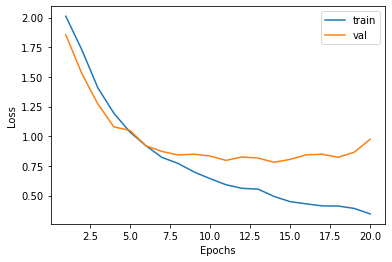

In [ ]:

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

total_train_losses = []
total_val_losses = []

for epoch in range(1,epochs+1):
    print(f"EPOCH NUMBER: {epoch}")
    model.train()
    train_losses = []
    confusion_matrix.reset()

    for i, batch in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch=img_batch.to(device), lbl_batch.to(device)
        optimizer.zero_grad()
        outputs = model(img_batch.float())
        loss=criterion(outputs, lbl_batch.long())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())

        if i % 100 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))

    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    

    model.eval()
    val_losses = []
    confusion_matrix.reset()

    for i, batch, in enumerate(tqdm(val_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch=img_batch.to(device), lbl_batch.to(device)
   

        with torch.no_grad():
          outputs=model(img_batch.float())
          loss=criterion(outputs, lbl_batch.long())
          _, predictions = torch.max(outputs, 1)

          for label, prediction in zip(lbl_batch.long(), predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

       

        confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
        val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)

    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

save_graph(total_train_losses, total_val_losses, epochs, save_folder)

 # *****END CODE

### 1d) Validate your model

- Show that the model is not overfitting
- How does your model perform ?

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report 

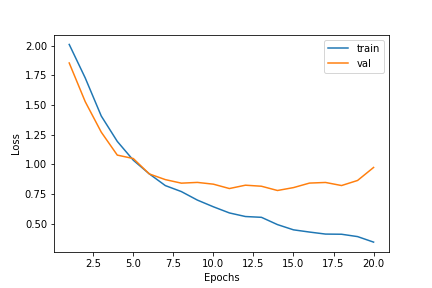

In [ ]:
import cv2 as cv2
from google.colab.patches import cv2_imshow
img = cv2.imread(save_folder + '/chart.png')
cv2_imshow(img)

In [ ]:

model = ConvNet().to(device)
model.load_state_dict(torch.load(save_folder + '/model_8.pt'))

<All keys matched successfully>

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

In [ ]:

model.eval()
val_losses = []
val_lbl = torch.Tensor([])
val_preds = torch.Tensor([])


total_train_losses = []
total_val_losses = []

with torch.no_grad():

    for i, batch, in enumerate(tqdm(val_dataloader)):
        img_batch, lbl_batch = batch
        val_lbl=torch.cat((val_lbl, lbl_batch))
        img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)

        logits=model(img_batch)
        val_preds=torch.cat((val_preds, logits.argmax(1).cpu()))
        loss=criterion(logits, lbl_batch)
        val_losses.append(loss.item())

      
        _, predictions = torch.max(logits, 1)
        for label, prediction in zip(lbl_batch.long(), predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


val_acc=accuracy(val_preds, val_lbl)
val_loss_mean = np.mean(val_losses)
total_val_losses.append(val_loss_mean)


print(f'Accuracy: {accuracy(val_lbl, val_preds)}')
print(classification_report(val_lbl, val_preds, target_names=classes))

100%|██████████| 157/157 [00:12<00:00, 12.22it/s]


Accuracy: 0.714900016784668
              precision    recall  f1-score   support

       plane       0.68      0.84      0.75      1000
         car       0.87      0.90      0.88      1000
        bird       0.62      0.46      0.53      1000
         cat       0.42      0.60      0.49      1000
        deer       0.79      0.49      0.60      1000
         dog       0.66      0.61      0.64      1000
        frog       0.81      0.76      0.78      1000
       horse       0.74      0.83      0.78      1000
        ship       0.85      0.84      0.85      1000
       truck       0.84      0.82      0.83      1000

    accuracy                           0.71     10000
   macro avg       0.73      0.71      0.71     10000
weighted avg       0.73      0.71      0.71     10000



In [ ]:

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 84.4 %
Accuracy for class: car   is 89.5 %
Accuracy for class: bird  is 45.8 %
Accuracy for class: cat   is 60.0 %
Accuracy for class: deer  is 49.0 %
Accuracy for class: dog   is 61.4 %
Accuracy for class: frog  is 75.6 %
Accuracy for class: horse is 82.7 %
Accuracy for class: ship  is 84.0 %
Accuracy for class: truck is 82.5 %


### 1e) Try to optimize hyperparameters, does it improve the performance of your model ?
Anwser with a graph and comment on the result.

In [ ]:
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U tensorboardx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from filelock import FileLock
from torch.utils.data import random_split

from functools import partial
import os

import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
def load_data(data_dir="./data"):
  
  with FileLock(os.path.expanduser("~/.data.lock")):
    
    transform_train = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
      ])

    transform_test = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
      ])


    batch_size=64
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
  
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
    return trainset, testset

def train_cifar(config,  epochs = 1):
    net = ConvNet().to(device)



    optimizer = optim.Adam(net.parameters(), lr=config["lr"], betas=(config["beta1"],config["beta2"]), amsgrad=config["amsgrad"], weight_decay=config["wd"])
    criterion = nn.CrossEntropyLoss().to(device)

    loaded_checkpoint = session.get_checkpoint()

    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    data_dir = os.path.abspath("./data")

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader( train_subset, batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)


            optimizer.zero_grad()


            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        os.makedirs("my_model", exist_ok=True)
        torch.save((net.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("my_model")
        session.report({"loss": (val_loss / val_steps), "accuracy": correct / total}, checkpoint=checkpoint)

    print("Finished Training")

def test_best_model(best_result):
    best_trained_model = ConvNet()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_trained_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    print("Best test set accuracy: {}".format(correct / total))

def main(num_samples=10, max_num_epochs=50, gpus_per_trial=1):

    config = {
            "lr": tune.loguniform(5*1e-4, 5*1e-2),
            "beta1": 0.9,
            "beta2": 0.999,
            "wd" : 1e-4,
            "amsgrad": tune.choice([True, False])
        }

    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_cifar),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))

    test_best_model(best_result)
    return(best_result.config)


In [ ]:
config = main(num_samples=10, max_num_epochs=50, gpus_per_trial=1)

2023-01-25 07:20:53,880	WARNING tune.py:690 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-01-25 07:20:59,336	ERROR tune.py:758 -- Trials did not complete: [train_cifar_cbb66_00000, train_cifar_cbb66_00001, train_cifar_cbb66_00002, train_cifar_cbb66_00003, train_cifar_cbb66_00004, train_cifar_cbb66_00005, train_cifar_cbb66_00006, train_cifar_cbb66_00007, train_cifar_cbb66_00008, train_cifar_cbb66_00009]
2023-01-25 07:20:59,339	INFO tune.py:762 -- Total run time: 8.78 seconds (8.51 seconds for the tuning loop).
2023-01-25 07:20:59,340	WARNING tune.py:768 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`
2023-01-25 07:20:59,351	WARNING experiment_analysis.py:627 -- Could not find best trial. Did you pass the correct `metric` parameter?


RuntimeError: ignored

In [ ]:


model = ConvNet().to(device)
validate_network(model, my_architecture_dict)

optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["wd"])
criterion = nn.CrossEntropyLoss()
epochs = 30




In [ ]:
# create a directory for saving the tuned models and the training progress
save_folder = 'drive/MyDrive/FDL_Optimized'

  0%|          | 2/782 [00:00<01:13, 10.66it/s]

Train (epoch 1/30) [0/782 (0%)]	Loss: 2.302193


 13%|█▎        | 104/782 [00:06<00:35, 19.02it/s]

Train (epoch 1/30) [100/782 (13%)]	Loss: 2.302238


 26%|██▌       | 204/782 [00:12<00:31, 18.44it/s]

Train (epoch 1/30) [200/782 (26%)]	Loss: 2.302437


 39%|███▉      | 304/782 [00:17<00:25, 18.91it/s]

Train (epoch 1/30) [300/782 (38%)]	Loss: 2.303431


 52%|█████▏    | 404/782 [00:22<00:20, 18.66it/s]

Train (epoch 1/30) [400/782 (51%)]	Loss: 2.307433


 64%|██████▍   | 504/782 [00:28<00:14, 18.92it/s]

Train (epoch 1/30) [500/782 (64%)]	Loss: 2.303376


 77%|███████▋  | 604/782 [00:33<00:09, 18.49it/s]

Train (epoch 1/30) [600/782 (77%)]	Loss: 2.304129


 90%|█████████ | 704/782 [00:38<00:04, 18.35it/s]

Train (epoch 1/30) [700/782 (90%)]	Loss: 2.303474


100%|██████████| 157/157 [00:04<00:00, 33.55it/s]


Confusion Matrix:
[[   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.772
VAL_LOSS:  2.303 VAL_ACC:  10.000


  0%|          | 2/782 [00:00<00:57, 13.65it/s]

Train (epoch 2/30) [0/782 (0%)]	Loss: 2.299362


 13%|█▎        | 102/782 [00:07<00:51, 13.21it/s]

Train (epoch 2/30) [100/782 (13%)]	Loss: 2.302965


 26%|██▌       | 204/782 [00:13<00:34, 16.56it/s]

Train (epoch 2/30) [200/782 (26%)]	Loss: 2.303008


 39%|███▉      | 304/782 [00:18<00:24, 19.15it/s]

Train (epoch 2/30) [300/782 (38%)]	Loss: 2.301634


 52%|█████▏    | 404/782 [00:24<00:20, 18.80it/s]

Train (epoch 2/30) [400/782 (51%)]	Loss: 2.302450


 64%|██████▍   | 504/782 [00:29<00:14, 19.05it/s]

Train (epoch 2/30) [500/782 (64%)]	Loss: 2.301650


 77%|███████▋  | 604/782 [00:35<00:09, 18.59it/s]

Train (epoch 2/30) [600/782 (77%)]	Loss: 2.303674


 90%|█████████ | 704/782 [00:41<00:04, 18.64it/s]

Train (epoch 2/30) [700/782 (90%)]	Loss: 2.302819


100%|██████████| 157/157 [00:04<00:00, 38.40it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.822
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:43, 17.98it/s]

Train (epoch 3/30) [0/782 (0%)]	Loss: 2.301842


 13%|█▎        | 104/782 [00:05<00:35, 18.88it/s]

Train (epoch 3/30) [100/782 (13%)]	Loss: 2.302358


 26%|██▌       | 204/782 [00:10<00:30, 19.11it/s]

Train (epoch 3/30) [200/782 (26%)]	Loss: 2.299832


 39%|███▉      | 304/782 [00:16<00:25, 18.40it/s]

Train (epoch 3/30) [300/782 (38%)]	Loss: 2.304015


 52%|█████▏    | 404/782 [00:21<00:20, 18.60it/s]

Train (epoch 3/30) [400/782 (51%)]	Loss: 2.304079


 64%|██████▍   | 504/782 [00:26<00:14, 18.73it/s]

Train (epoch 3/30) [500/782 (64%)]	Loss: 2.302287


 77%|███████▋  | 604/782 [00:32<00:09, 19.04it/s]

Train (epoch 3/30) [600/782 (77%)]	Loss: 2.300954


 90%|█████████ | 704/782 [00:37<00:04, 19.30it/s]

Train (epoch 3/30) [700/782 (90%)]	Loss: 2.303886


100%|██████████| 157/157 [00:04<00:00, 38.71it/s]


Confusion Matrix:
[[   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  10.034
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:42, 18.23it/s]

Train (epoch 4/30) [0/782 (0%)]	Loss: 2.301964


 13%|█▎        | 104/782 [00:05<00:35, 19.04it/s]

Train (epoch 4/30) [100/782 (13%)]	Loss: 2.303181


 26%|██▌       | 204/782 [00:10<00:30, 18.80it/s]

Train (epoch 4/30) [200/782 (26%)]	Loss: 2.304184


 39%|███▉      | 304/782 [00:16<00:25, 18.96it/s]

Train (epoch 4/30) [300/782 (38%)]	Loss: 2.302753


 52%|█████▏    | 404/782 [00:21<00:19, 18.93it/s]

Train (epoch 4/30) [400/782 (51%)]	Loss: 2.300383


 64%|██████▍   | 504/782 [00:26<00:14, 19.00it/s]

Train (epoch 4/30) [500/782 (64%)]	Loss: 2.304416


 77%|███████▋  | 604/782 [00:32<00:09, 19.10it/s]

Train (epoch 4/30) [600/782 (77%)]	Loss: 2.303706


 90%|█████████ | 704/782 [00:37<00:04, 19.08it/s]

Train (epoch 4/30) [700/782 (90%)]	Loss: 2.300373


100%|██████████| 157/157 [00:04<00:00, 38.10it/s]


Confusion Matrix:
[[   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.834
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:43, 17.86it/s]

Train (epoch 5/30) [0/782 (0%)]	Loss: 2.304979


 13%|█▎        | 104/782 [00:05<00:36, 18.48it/s]

Train (epoch 5/30) [100/782 (13%)]	Loss: 2.299936


 26%|██▌       | 204/782 [00:11<00:31, 18.53it/s]

Train (epoch 5/30) [200/782 (26%)]	Loss: 2.303385


 39%|███▉      | 304/782 [00:16<00:25, 19.07it/s]

Train (epoch 5/30) [300/782 (38%)]	Loss: 2.301735


 52%|█████▏    | 404/782 [00:21<00:19, 19.26it/s]

Train (epoch 5/30) [400/782 (51%)]	Loss: 2.299996


 64%|██████▍   | 504/782 [00:26<00:14, 18.76it/s]

Train (epoch 5/30) [500/782 (64%)]	Loss: 2.301296


 77%|███████▋  | 604/782 [00:32<00:09, 19.09it/s]

Train (epoch 5/30) [600/782 (77%)]	Loss: 2.303774


 90%|█████████ | 704/782 [00:37<00:04, 19.15it/s]

Train (epoch 5/30) [700/782 (90%)]	Loss: 2.301739


100%|██████████| 157/157 [00:04<00:00, 38.63it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.756
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:45, 17.21it/s]

Train (epoch 6/30) [0/782 (0%)]	Loss: 2.305227


 13%|█▎        | 104/782 [00:05<00:36, 18.61it/s]

Train (epoch 6/30) [100/782 (13%)]	Loss: 2.303358


 26%|██▌       | 204/782 [00:10<00:30, 19.02it/s]

Train (epoch 6/30) [200/782 (26%)]	Loss: 2.303933


 39%|███▉      | 304/782 [00:16<00:25, 18.94it/s]

Train (epoch 6/30) [300/782 (38%)]	Loss: 2.303636


 52%|█████▏    | 404/782 [00:21<00:20, 18.71it/s]

Train (epoch 6/30) [400/782 (51%)]	Loss: 2.303364


 64%|██████▍   | 504/782 [00:26<00:14, 18.92it/s]

Train (epoch 6/30) [500/782 (64%)]	Loss: 2.301416


 77%|███████▋  | 604/782 [00:32<00:09, 18.98it/s]

Train (epoch 6/30) [600/782 (77%)]	Loss: 2.303310


 90%|█████████ | 704/782 [00:37<00:04, 18.94it/s]

Train (epoch 6/30) [700/782 (90%)]	Loss: 2.301811


100%|██████████| 157/157 [00:04<00:00, 38.09it/s]


Confusion Matrix:
[[   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.902
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.64it/s]

Train (epoch 7/30) [0/782 (0%)]	Loss: 2.303297


 13%|█▎        | 104/782 [00:05<00:37, 18.13it/s]

Train (epoch 7/30) [100/782 (13%)]	Loss: 2.299960


 26%|██▌       | 204/782 [00:10<00:30, 18.72it/s]

Train (epoch 7/30) [200/782 (26%)]	Loss: 2.302737


 39%|███▉      | 304/782 [00:16<00:25, 19.00it/s]

Train (epoch 7/30) [300/782 (38%)]	Loss: 2.301899


 52%|█████▏    | 404/782 [00:21<00:19, 19.05it/s]

Train (epoch 7/30) [400/782 (51%)]	Loss: 2.303201


 64%|██████▍   | 504/782 [00:26<00:14, 18.81it/s]

Train (epoch 7/30) [500/782 (64%)]	Loss: 2.301946


 77%|███████▋  | 604/782 [00:32<00:09, 19.07it/s]

Train (epoch 7/30) [600/782 (77%)]	Loss: 2.303713


 90%|█████████ | 704/782 [00:37<00:04, 19.22it/s]

Train (epoch 7/30) [700/782 (90%)]	Loss: 2.300820


100%|██████████| 157/157 [00:06<00:00, 23.67it/s]


Confusion Matrix:
[[   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.886
VAL_LOSS:  2.303 VAL_ACC:  10.000


  0%|          | 3/782 [00:00<01:15, 10.33it/s]

Train (epoch 8/30) [0/782 (0%)]	Loss: 2.303128


 13%|█▎        | 103/782 [00:06<00:36, 18.57it/s]

Train (epoch 8/30) [100/782 (13%)]	Loss: 2.301330


 26%|██▌       | 203/782 [00:11<00:30, 19.06it/s]

Train (epoch 8/30) [200/782 (26%)]	Loss: 2.300931


 39%|███▊      | 303/782 [00:16<00:25, 18.83it/s]

Train (epoch 8/30) [300/782 (38%)]	Loss: 2.300480


 52%|█████▏    | 403/782 [00:22<00:19, 19.01it/s]

Train (epoch 8/30) [400/782 (51%)]	Loss: 2.300058


 64%|██████▍   | 503/782 [00:27<00:14, 18.98it/s]

Train (epoch 8/30) [500/782 (64%)]	Loss: 2.302372


 77%|███████▋  | 603/782 [00:32<00:09, 18.92it/s]

Train (epoch 8/30) [600/782 (77%)]	Loss: 2.301577


 90%|████████▉ | 703/782 [00:38<00:04, 18.71it/s]

Train (epoch 8/30) [700/782 (90%)]	Loss: 2.302774


100%|██████████| 157/157 [00:04<00:00, 37.96it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.740
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:46, 16.83it/s]

Train (epoch 9/30) [0/782 (0%)]	Loss: 2.302475


 13%|█▎        | 104/782 [00:05<00:36, 18.83it/s]

Train (epoch 9/30) [100/782 (13%)]	Loss: 2.307127


 26%|██▌       | 204/782 [00:10<00:30, 18.98it/s]

Train (epoch 9/30) [200/782 (26%)]	Loss: 2.301209


 39%|███▉      | 304/782 [00:16<00:25, 18.98it/s]

Train (epoch 9/30) [300/782 (38%)]	Loss: 2.302176


 52%|█████▏    | 404/782 [00:21<00:20, 18.49it/s]

Train (epoch 9/30) [400/782 (51%)]	Loss: 2.303410


 64%|██████▍   | 504/782 [00:26<00:14, 18.92it/s]

Train (epoch 9/30) [500/782 (64%)]	Loss: 2.302767


 77%|███████▋  | 604/782 [00:32<00:09, 18.76it/s]

Train (epoch 9/30) [600/782 (77%)]	Loss: 2.303048


 90%|█████████ | 704/782 [00:37<00:04, 18.93it/s]

Train (epoch 9/30) [700/782 (90%)]	Loss: 2.302979


100%|██████████| 157/157 [00:04<00:00, 38.31it/s]


Confusion Matrix:
[[   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.846
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.54it/s]

Train (epoch 10/30) [0/782 (0%)]	Loss: 2.301875


 13%|█▎        | 104/782 [00:05<00:36, 18.68it/s]

Train (epoch 10/30) [100/782 (13%)]	Loss: 2.304966


 26%|██▌       | 204/782 [00:11<00:30, 18.88it/s]

Train (epoch 10/30) [200/782 (26%)]	Loss: 2.301909


 39%|███▉      | 304/782 [00:16<00:25, 19.04it/s]

Train (epoch 10/30) [300/782 (38%)]	Loss: 2.301756


 52%|█████▏    | 404/782 [00:21<00:19, 19.03it/s]

Train (epoch 10/30) [400/782 (51%)]	Loss: 2.298429


 64%|██████▍   | 504/782 [00:26<00:14, 18.85it/s]

Train (epoch 10/30) [500/782 (64%)]	Loss: 2.300313


 77%|███████▋  | 604/782 [00:32<00:09, 19.19it/s]

Train (epoch 10/30) [600/782 (77%)]	Loss: 2.308848


 90%|█████████ | 704/782 [00:37<00:04, 18.60it/s]

Train (epoch 10/30) [700/782 (90%)]	Loss: 2.303324


100%|██████████| 157/157 [00:04<00:00, 37.28it/s]


Confusion Matrix:
[[   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.876
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:43, 17.71it/s]

Train (epoch 11/30) [0/782 (0%)]	Loss: 2.301178


 13%|█▎        | 104/782 [00:05<00:36, 18.45it/s]

Train (epoch 11/30) [100/782 (13%)]	Loss: 2.303375


 26%|██▌       | 204/782 [00:11<00:30, 18.68it/s]

Train (epoch 11/30) [200/782 (26%)]	Loss: 2.302702


 39%|███▉      | 304/782 [00:16<00:25, 18.99it/s]

Train (epoch 11/30) [300/782 (38%)]	Loss: 2.302443


 52%|█████▏    | 404/782 [00:21<00:20, 18.55it/s]

Train (epoch 11/30) [400/782 (51%)]	Loss: 2.301291


 64%|██████▍   | 504/782 [00:26<00:14, 18.67it/s]

Train (epoch 11/30) [500/782 (64%)]	Loss: 2.302020


 77%|███████▋  | 604/782 [00:32<00:09, 18.28it/s]

Train (epoch 11/30) [600/782 (77%)]	Loss: 2.303912


 90%|█████████ | 704/782 [00:37<00:04, 19.02it/s]

Train (epoch 11/30) [700/782 (90%)]	Loss: 2.302670


100%|██████████| 157/157 [00:04<00:00, 37.15it/s]


Confusion Matrix:
[[   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.974
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:45, 17.12it/s]

Train (epoch 12/30) [0/782 (0%)]	Loss: 2.300536


 13%|█▎        | 104/782 [00:05<00:36, 18.65it/s]

Train (epoch 12/30) [100/782 (13%)]	Loss: 2.303656


 26%|██▌       | 204/782 [00:11<00:30, 19.03it/s]

Train (epoch 12/30) [200/782 (26%)]	Loss: 2.302103


 39%|███▉      | 304/782 [00:16<00:25, 18.79it/s]

Train (epoch 12/30) [300/782 (38%)]	Loss: 2.304294


 52%|█████▏    | 404/782 [00:21<00:20, 18.89it/s]

Train (epoch 12/30) [400/782 (51%)]	Loss: 2.303640


 64%|██████▍   | 504/782 [00:27<00:14, 18.97it/s]

Train (epoch 12/30) [500/782 (64%)]	Loss: 2.301379


 77%|███████▋  | 604/782 [00:32<00:09, 19.08it/s]

Train (epoch 12/30) [600/782 (77%)]	Loss: 2.302549


 90%|█████████ | 704/782 [00:37<00:04, 18.42it/s]

Train (epoch 12/30) [700/782 (90%)]	Loss: 2.302644


100%|██████████| 157/157 [00:04<00:00, 37.13it/s]


Confusion Matrix:
[[   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.698
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:46, 16.79it/s]

Train (epoch 13/30) [0/782 (0%)]	Loss: 2.303533


 13%|█▎        | 104/782 [00:05<00:36, 18.81it/s]

Train (epoch 13/30) [100/782 (13%)]	Loss: 2.302878


 26%|██▌       | 204/782 [00:11<00:30, 18.87it/s]

Train (epoch 13/30) [200/782 (26%)]	Loss: 2.303438


 39%|███▉      | 304/782 [00:16<00:25, 19.11it/s]

Train (epoch 13/30) [300/782 (38%)]	Loss: 2.302245


 52%|█████▏    | 404/782 [00:21<00:21, 17.80it/s]

Train (epoch 13/30) [400/782 (51%)]	Loss: 2.303290


 64%|██████▍   | 504/782 [00:26<00:14, 18.96it/s]

Train (epoch 13/30) [500/782 (64%)]	Loss: 2.302227


 77%|███████▋  | 604/782 [00:32<00:09, 18.27it/s]

Train (epoch 13/30) [600/782 (77%)]	Loss: 2.302891


 90%|█████████ | 704/782 [00:37<00:04, 18.82it/s]

Train (epoch 13/30) [700/782 (90%)]	Loss: 2.304866


100%|██████████| 157/157 [00:04<00:00, 37.81it/s]


Confusion Matrix:
[[   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  10.008
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.43it/s]

Train (epoch 14/30) [0/782 (0%)]	Loss: 2.303446


 13%|█▎        | 104/782 [00:05<00:41, 16.23it/s]

Train (epoch 14/30) [100/782 (13%)]	Loss: 2.301654


 26%|██▌       | 202/782 [00:12<00:36, 15.70it/s]

Train (epoch 14/30) [200/782 (26%)]	Loss: 2.304911


 39%|███▉      | 304/782 [00:18<00:26, 17.92it/s]

Train (epoch 14/30) [300/782 (38%)]	Loss: 2.304993


 52%|█████▏    | 404/782 [00:24<00:20, 18.72it/s]

Train (epoch 14/30) [400/782 (51%)]	Loss: 2.302062


 64%|██████▍   | 504/782 [00:29<00:14, 19.03it/s]

Train (epoch 14/30) [500/782 (64%)]	Loss: 2.302531


 77%|███████▋  | 604/782 [00:34<00:09, 19.15it/s]

Train (epoch 14/30) [600/782 (77%)]	Loss: 2.303703


 90%|█████████ | 704/782 [00:40<00:04, 18.59it/s]

Train (epoch 14/30) [700/782 (90%)]	Loss: 2.303663


100%|██████████| 157/157 [00:04<00:00, 37.85it/s]


Confusion Matrix:
[[   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.922
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:43, 17.77it/s]

Train (epoch 15/30) [0/782 (0%)]	Loss: 2.302782


 13%|█▎        | 104/782 [00:05<00:35, 18.86it/s]

Train (epoch 15/30) [100/782 (13%)]	Loss: 2.302973


 26%|██▌       | 204/782 [00:11<00:29, 19.27it/s]

Train (epoch 15/30) [200/782 (26%)]	Loss: 2.302557


 39%|███▉      | 304/782 [00:16<00:25, 18.77it/s]

Train (epoch 15/30) [300/782 (38%)]	Loss: 2.303674


 52%|█████▏    | 404/782 [00:21<00:20, 18.67it/s]

Train (epoch 15/30) [400/782 (51%)]	Loss: 2.302968


 64%|██████▍   | 504/782 [00:27<00:14, 18.78it/s]

Train (epoch 15/30) [500/782 (64%)]	Loss: 2.302958


 77%|███████▋  | 604/782 [00:32<00:09, 18.95it/s]

Train (epoch 15/30) [600/782 (77%)]	Loss: 2.303993


 90%|█████████ | 704/782 [00:37<00:04, 18.94it/s]

Train (epoch 15/30) [700/782 (90%)]	Loss: 2.301399


100%|██████████| 157/157 [00:04<00:00, 37.93it/s]


Confusion Matrix:
[[   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.858
VAL_LOSS:  2.304 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.53it/s]

Train (epoch 16/30) [0/782 (0%)]	Loss: 2.295130


 13%|█▎        | 104/782 [00:05<00:36, 18.82it/s]

Train (epoch 16/30) [100/782 (13%)]	Loss: 2.302972


 26%|██▌       | 204/782 [00:11<00:31, 18.45it/s]

Train (epoch 16/30) [200/782 (26%)]	Loss: 2.299054


 39%|███▉      | 304/782 [00:16<00:25, 18.69it/s]

Train (epoch 16/30) [300/782 (38%)]	Loss: 2.299609


 52%|█████▏    | 404/782 [00:21<00:20, 18.67it/s]

Train (epoch 16/30) [400/782 (51%)]	Loss: 2.302368


 64%|██████▍   | 504/782 [00:27<00:14, 18.79it/s]

Train (epoch 16/30) [500/782 (64%)]	Loss: 2.302997


 77%|███████▋  | 604/782 [00:32<00:09, 18.64it/s]

Train (epoch 16/30) [600/782 (77%)]	Loss: 2.298500


 90%|█████████ | 704/782 [00:37<00:04, 18.85it/s]

Train (epoch 16/30) [700/782 (90%)]	Loss: 2.301720


100%|██████████| 157/157 [00:04<00:00, 37.51it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  10.058
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.30it/s]

Train (epoch 17/30) [0/782 (0%)]	Loss: 2.303563


 13%|█▎        | 104/782 [00:05<00:36, 18.76it/s]

Train (epoch 17/30) [100/782 (13%)]	Loss: 2.301263


 26%|██▌       | 204/782 [00:11<00:30, 18.70it/s]

Train (epoch 17/30) [200/782 (26%)]	Loss: 2.303788


 39%|███▉      | 304/782 [00:16<00:25, 18.67it/s]

Train (epoch 17/30) [300/782 (38%)]	Loss: 2.302176


 52%|█████▏    | 404/782 [00:21<00:19, 18.98it/s]

Train (epoch 17/30) [400/782 (51%)]	Loss: 2.304383


 64%|██████▍   | 504/782 [00:27<00:14, 18.78it/s]

Train (epoch 17/30) [500/782 (64%)]	Loss: 2.304193


 77%|███████▋  | 604/782 [00:32<00:09, 18.82it/s]

Train (epoch 17/30) [600/782 (77%)]	Loss: 2.297770


 90%|█████████ | 704/782 [00:37<00:04, 18.76it/s]

Train (epoch 17/30) [700/782 (90%)]	Loss: 2.303913


100%|██████████| 157/157 [00:04<00:00, 37.76it/s]


Confusion Matrix:
[[   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  10.112
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:46, 16.56it/s]

Train (epoch 18/30) [0/782 (0%)]	Loss: 2.303613


 13%|█▎        | 104/782 [00:05<00:37, 18.10it/s]

Train (epoch 18/30) [100/782 (13%)]	Loss: 2.301380


 26%|██▌       | 204/782 [00:11<00:30, 18.88it/s]

Train (epoch 18/30) [200/782 (26%)]	Loss: 2.302618


 39%|███▉      | 304/782 [00:16<00:25, 18.89it/s]

Train (epoch 18/30) [300/782 (38%)]	Loss: 2.301490


 52%|█████▏    | 404/782 [00:21<00:20, 18.43it/s]

Train (epoch 18/30) [400/782 (51%)]	Loss: 2.302478


 64%|██████▍   | 504/782 [00:27<00:14, 18.74it/s]

Train (epoch 18/30) [500/782 (64%)]	Loss: 2.302795


 77%|███████▋  | 604/782 [00:32<00:09, 18.52it/s]

Train (epoch 18/30) [600/782 (77%)]	Loss: 2.302827


 90%|█████████ | 704/782 [00:38<00:04, 18.03it/s]

Train (epoch 18/30) [700/782 (90%)]	Loss: 2.303231


100%|██████████| 157/157 [00:04<00:00, 37.02it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.708
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.33it/s]

Train (epoch 19/30) [0/782 (0%)]	Loss: 2.305181


 13%|█▎        | 104/782 [00:05<00:36, 18.48it/s]

Train (epoch 19/30) [100/782 (13%)]	Loss: 2.301470


 26%|██▌       | 204/782 [00:11<00:30, 18.78it/s]

Train (epoch 19/30) [200/782 (26%)]	Loss: 2.303194


 39%|███▉      | 304/782 [00:16<00:25, 18.55it/s]

Train (epoch 19/30) [300/782 (38%)]	Loss: 2.302157


 52%|█████▏    | 404/782 [00:21<00:20, 18.69it/s]

Train (epoch 19/30) [400/782 (51%)]	Loss: 2.301985


 64%|██████▍   | 504/782 [00:27<00:14, 18.54it/s]

Train (epoch 19/30) [500/782 (64%)]	Loss: 2.302701


 77%|███████▋  | 604/782 [00:32<00:09, 18.26it/s]

Train (epoch 19/30) [600/782 (77%)]	Loss: 2.302574


 90%|█████████ | 704/782 [00:37<00:04, 18.62it/s]

Train (epoch 19/30) [700/782 (90%)]	Loss: 2.303886


100%|██████████| 157/157 [00:04<00:00, 36.89it/s]


Confusion Matrix:
[[   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.660
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.42it/s]

Train (epoch 20/30) [0/782 (0%)]	Loss: 2.301755


 13%|█▎        | 104/782 [00:05<00:36, 18.62it/s]

Train (epoch 20/30) [100/782 (13%)]	Loss: 2.302418


 26%|██▌       | 204/782 [00:11<00:32, 18.03it/s]

Train (epoch 20/30) [200/782 (26%)]	Loss: 2.303831


 39%|███▉      | 304/782 [00:16<00:28, 16.94it/s]

Train (epoch 20/30) [300/782 (38%)]	Loss: 2.303624


 51%|█████▏    | 402/782 [00:22<00:25, 14.68it/s]

Train (epoch 20/30) [400/782 (51%)]	Loss: 2.303864


 64%|██████▍   | 504/782 [00:29<00:15, 18.07it/s]

Train (epoch 20/30) [500/782 (64%)]	Loss: 2.303674


 77%|███████▋  | 604/782 [00:34<00:09, 18.89it/s]

Train (epoch 20/30) [600/782 (77%)]	Loss: 2.303820


 90%|█████████ | 704/782 [00:40<00:04, 18.68it/s]

Train (epoch 20/30) [700/782 (90%)]	Loss: 2.302514


100%|██████████| 157/157 [00:04<00:00, 38.19it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.794
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:43, 17.87it/s]

Train (epoch 21/30) [0/782 (0%)]	Loss: 2.300598


 13%|█▎        | 104/782 [00:05<00:36, 18.64it/s]

Train (epoch 21/30) [100/782 (13%)]	Loss: 2.304334


 26%|██▌       | 204/782 [00:11<00:31, 18.54it/s]

Train (epoch 21/30) [200/782 (26%)]	Loss: 2.303521


 39%|███▉      | 304/782 [00:16<00:26, 18.29it/s]

Train (epoch 21/30) [300/782 (38%)]	Loss: 2.301443


 52%|█████▏    | 404/782 [00:21<00:19, 18.96it/s]

Train (epoch 21/30) [400/782 (51%)]	Loss: 2.299157


 64%|██████▍   | 504/782 [00:27<00:14, 18.72it/s]

Train (epoch 21/30) [500/782 (64%)]	Loss: 2.306273


 77%|███████▋  | 604/782 [00:32<00:09, 19.03it/s]

Train (epoch 21/30) [600/782 (77%)]	Loss: 2.303392


 90%|█████████ | 704/782 [00:37<00:04, 18.68it/s]

Train (epoch 21/30) [700/782 (90%)]	Loss: 2.301982


100%|██████████| 157/157 [00:04<00:00, 37.10it/s]


Confusion Matrix:
[[   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  10.048
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.48it/s]

Train (epoch 22/30) [0/782 (0%)]	Loss: 2.302894


 13%|█▎        | 104/782 [00:05<00:35, 19.01it/s]

Train (epoch 22/30) [100/782 (13%)]	Loss: 2.300954


 26%|██▌       | 204/782 [00:11<00:30, 18.97it/s]

Train (epoch 22/30) [200/782 (26%)]	Loss: 2.299912


 39%|███▉      | 304/782 [00:16<00:25, 18.78it/s]

Train (epoch 22/30) [300/782 (38%)]	Loss: 2.304900


 52%|█████▏    | 404/782 [00:21<00:20, 18.90it/s]

Train (epoch 22/30) [400/782 (51%)]	Loss: 2.307758


 64%|██████▍   | 504/782 [00:27<00:15, 18.15it/s]

Train (epoch 22/30) [500/782 (64%)]	Loss: 2.301223


 77%|███████▋  | 604/782 [00:32<00:09, 18.81it/s]

Train (epoch 22/30) [600/782 (77%)]	Loss: 2.302928


 90%|█████████ | 704/782 [00:37<00:04, 18.75it/s]

Train (epoch 22/30) [700/782 (90%)]	Loss: 2.302745


100%|██████████| 157/157 [00:04<00:00, 37.28it/s]


Confusion Matrix:
[[   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.926
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.56it/s]

Train (epoch 23/30) [0/782 (0%)]	Loss: 2.304198


 13%|█▎        | 104/782 [00:05<00:36, 18.36it/s]

Train (epoch 23/30) [100/782 (13%)]	Loss: 2.302754


 26%|██▌       | 204/782 [00:11<00:30, 18.90it/s]

Train (epoch 23/30) [200/782 (26%)]	Loss: 2.302365


 39%|███▉      | 304/782 [00:16<00:25, 18.64it/s]

Train (epoch 23/30) [300/782 (38%)]	Loss: 2.302105


 52%|█████▏    | 404/782 [00:21<00:20, 18.85it/s]

Train (epoch 23/30) [400/782 (51%)]	Loss: 2.301792


 64%|██████▍   | 504/782 [00:27<00:14, 18.66it/s]

Train (epoch 23/30) [500/782 (64%)]	Loss: 2.303596


 77%|███████▋  | 604/782 [00:32<00:09, 18.79it/s]

Train (epoch 23/30) [600/782 (77%)]	Loss: 2.309759


 90%|█████████ | 704/782 [00:37<00:04, 18.71it/s]

Train (epoch 23/30) [700/782 (90%)]	Loss: 2.302304


100%|██████████| 157/157 [00:04<00:00, 37.70it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.876
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.48it/s]

Train (epoch 24/30) [0/782 (0%)]	Loss: 2.302831


 13%|█▎        | 104/782 [00:05<00:36, 18.62it/s]

Train (epoch 24/30) [100/782 (13%)]	Loss: 2.302474


 26%|██▌       | 204/782 [00:11<00:30, 18.89it/s]

Train (epoch 24/30) [200/782 (26%)]	Loss: 2.301165


 39%|███▉      | 304/782 [00:16<00:25, 18.62it/s]

Train (epoch 24/30) [300/782 (38%)]	Loss: 2.301904


 52%|█████▏    | 404/782 [00:21<00:19, 18.98it/s]

Train (epoch 24/30) [400/782 (51%)]	Loss: 2.301770


 64%|██████▍   | 504/782 [00:27<00:14, 18.75it/s]

Train (epoch 24/30) [500/782 (64%)]	Loss: 2.303218


 77%|███████▋  | 604/782 [00:32<00:09, 18.68it/s]

Train (epoch 24/30) [600/782 (77%)]	Loss: 2.301306


 90%|█████████ | 704/782 [00:37<00:04, 18.70it/s]

Train (epoch 24/30) [700/782 (90%)]	Loss: 2.304119


100%|██████████| 157/157 [00:04<00:00, 37.85it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.688
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.55it/s]

Train (epoch 25/30) [0/782 (0%)]	Loss: 2.303720


 13%|█▎        | 102/782 [00:05<00:38, 17.83it/s]

Train (epoch 25/30) [100/782 (13%)]	Loss: 2.302323


 26%|██▌       | 204/782 [00:11<00:31, 18.40it/s]

Train (epoch 25/30) [200/782 (26%)]	Loss: 2.303471


 39%|███▉      | 304/782 [00:16<00:25, 18.69it/s]

Train (epoch 25/30) [300/782 (38%)]	Loss: 2.303509


 52%|█████▏    | 404/782 [00:22<00:20, 18.45it/s]

Train (epoch 25/30) [400/782 (51%)]	Loss: 2.303510


 64%|██████▍   | 504/782 [00:27<00:15, 18.45it/s]

Train (epoch 25/30) [500/782 (64%)]	Loss: 2.300482


 77%|███████▋  | 604/782 [00:32<00:09, 18.83it/s]

Train (epoch 25/30) [600/782 (77%)]	Loss: 2.303302


 90%|█████████ | 704/782 [00:38<00:04, 18.63it/s]

Train (epoch 25/30) [700/782 (90%)]	Loss: 2.301548


100%|██████████| 157/157 [00:04<00:00, 37.91it/s]


Confusion Matrix:
[[   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.744
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:45, 17.18it/s]

Train (epoch 26/30) [0/782 (0%)]	Loss: 2.302670


 13%|█▎        | 104/782 [00:05<00:36, 18.74it/s]

Train (epoch 26/30) [100/782 (13%)]	Loss: 2.303753


 26%|██▌       | 204/782 [00:11<00:30, 18.81it/s]

Train (epoch 26/30) [200/782 (26%)]	Loss: 2.306947


 39%|███▉      | 304/782 [00:16<00:25, 18.60it/s]

Train (epoch 26/30) [300/782 (38%)]	Loss: 2.303802


 51%|█████▏    | 402/782 [00:22<00:23, 15.85it/s]

Train (epoch 26/30) [400/782 (51%)]	Loss: 2.300617


 64%|██████▍   | 504/782 [00:28<00:18, 14.95it/s]

Train (epoch 26/30) [500/782 (64%)]	Loss: 2.300751


 77%|███████▋  | 604/782 [00:34<00:09, 18.52it/s]

Train (epoch 26/30) [600/782 (77%)]	Loss: 2.301700


 90%|█████████ | 704/782 [00:40<00:04, 18.71it/s]

Train (epoch 26/30) [700/782 (90%)]	Loss: 2.302441


100%|██████████| 157/157 [00:04<00:00, 37.12it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.624
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:45, 17.14it/s]

Train (epoch 27/30) [0/782 (0%)]	Loss: 2.302636


 13%|█▎        | 104/782 [00:05<00:37, 18.27it/s]

Train (epoch 27/30) [100/782 (13%)]	Loss: 2.303908


 26%|██▌       | 204/782 [00:11<00:31, 18.36it/s]

Train (epoch 27/30) [200/782 (26%)]	Loss: 2.303496


 39%|███▉      | 304/782 [00:16<00:25, 18.75it/s]

Train (epoch 27/30) [300/782 (38%)]	Loss: 2.301440


 52%|█████▏    | 404/782 [00:21<00:20, 18.75it/s]

Train (epoch 27/30) [400/782 (51%)]	Loss: 2.300356


 64%|██████▍   | 504/782 [00:27<00:14, 19.01it/s]

Train (epoch 27/30) [500/782 (64%)]	Loss: 2.303387


 77%|███████▋  | 604/782 [00:32<00:09, 18.39it/s]

Train (epoch 27/30) [600/782 (77%)]	Loss: 2.303267


 90%|█████████ | 704/782 [00:38<00:04, 18.61it/s]

Train (epoch 27/30) [700/782 (90%)]	Loss: 2.302949


100%|██████████| 157/157 [00:04<00:00, 37.94it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.758
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.57it/s]

Train (epoch 28/30) [0/782 (0%)]	Loss: 2.302123


 13%|█▎        | 104/782 [00:05<00:36, 18.75it/s]

Train (epoch 28/30) [100/782 (13%)]	Loss: 2.301275


 26%|██▌       | 204/782 [00:11<00:30, 18.77it/s]

Train (epoch 28/30) [200/782 (26%)]	Loss: 2.301672


 39%|███▉      | 304/782 [00:16<00:25, 18.83it/s]

Train (epoch 28/30) [300/782 (38%)]	Loss: 2.303079


 52%|█████▏    | 404/782 [00:21<00:20, 18.36it/s]

Train (epoch 28/30) [400/782 (51%)]	Loss: 2.302261


 64%|██████▍   | 504/782 [00:27<00:14, 18.68it/s]

Train (epoch 28/30) [500/782 (64%)]	Loss: 2.303019


 77%|███████▋  | 604/782 [00:32<00:09, 18.67it/s]

Train (epoch 28/30) [600/782 (77%)]	Loss: 2.302533


 90%|█████████ | 704/782 [00:37<00:04, 18.52it/s]

Train (epoch 28/30) [700/782 (90%)]	Loss: 2.303404


100%|██████████| 157/157 [00:04<00:00, 36.75it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0 1000    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.880
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:44, 17.61it/s]

Train (epoch 29/30) [0/782 (0%)]	Loss: 2.303106


 13%|█▎        | 104/782 [00:05<00:37, 18.11it/s]

Train (epoch 29/30) [100/782 (13%)]	Loss: 2.302032


 26%|██▌       | 204/782 [00:11<00:31, 18.53it/s]

Train (epoch 29/30) [200/782 (26%)]	Loss: 2.304986


 39%|███▉      | 304/782 [00:16<00:25, 18.80it/s]

Train (epoch 29/30) [300/782 (38%)]	Loss: 2.301286


 52%|█████▏    | 404/782 [00:21<00:20, 18.85it/s]

Train (epoch 29/30) [400/782 (51%)]	Loss: 2.302502


 64%|██████▍   | 504/782 [00:27<00:15, 18.31it/s]

Train (epoch 29/30) [500/782 (64%)]	Loss: 2.302505


 77%|███████▋  | 604/782 [00:32<00:09, 18.69it/s]

Train (epoch 29/30) [600/782 (77%)]	Loss: 2.302048


 90%|█████████ | 704/782 [00:38<00:04, 18.76it/s]

Train (epoch 29/30) [700/782 (90%)]	Loss: 2.302992


100%|██████████| 157/157 [00:04<00:00, 37.41it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.998
VAL_LOSS:  2.303 VAL_ACC:  10.000


  1%|          | 4/782 [00:00<00:43, 18.00it/s]

Train (epoch 30/30) [0/782 (0%)]	Loss: 2.304490


 13%|█▎        | 104/782 [00:05<00:36, 18.53it/s]

Train (epoch 30/30) [100/782 (13%)]	Loss: 2.300125


 26%|██▌       | 204/782 [00:11<00:31, 18.09it/s]

Train (epoch 30/30) [200/782 (26%)]	Loss: 2.303406


 39%|███▉      | 304/782 [00:16<00:25, 18.95it/s]

Train (epoch 30/30) [300/782 (38%)]	Loss: 2.303774


 52%|█████▏    | 404/782 [00:22<00:20, 18.62it/s]

Train (epoch 30/30) [400/782 (51%)]	Loss: 2.303231


 64%|██████▍   | 504/782 [00:27<00:15, 18.41it/s]

Train (epoch 30/30) [500/782 (64%)]	Loss: 2.301652


 77%|███████▋  | 604/782 [00:32<00:09, 18.70it/s]

Train (epoch 30/30) [600/782 (77%)]	Loss: 2.300832


 90%|█████████ | 704/782 [00:38<00:04, 18.56it/s]

Train (epoch 30/30) [700/782 (90%)]	Loss: 2.302078


100%|██████████| 157/157 [00:04<00:00, 37.09it/s]


Confusion Matrix:
[[   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]]
TRAIN_LOSS:  2.303 TRAIN_ACC:  9.902
VAL_LOSS:  2.303 VAL_ACC:  10.000


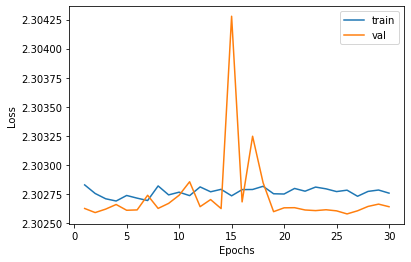

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

total_train_losses = []
total_val_losses = []

for epoch in range(1,epochs+1):

    model.train()
    train_losses = []
    confusion_matrix.reset()

    for i, batch, in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch=img_batch.to(device), lbl_batch.to(device)


        optimizer.zero_grad()
        outputs = model(img_batch.float())
        loss=criterion(outputs, lbl_batch.long())
        loss.backward()
        optimizer.step()


        train_losses.append(loss.item())
        confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())

        if i % 100 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))

    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    
    model.eval()
    val_losses = []
    confusion_matrix.reset()

    for i, batch, in enumerate(tqdm(val_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch=img_batch.to(device), lbl_batch.to(device)

        with torch.no_grad():
          outputs=model(img_batch.float())
          loss=criterion(outputs, lbl_batch.long())
          _, predictions = torch.max(outputs, 1)
          for label, prediction in zip(lbl_batch.long(), predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


        confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
        val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)

    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)

    write_results(save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

save_graph(total_train_losses, total_val_losses, epochs, save_folder)



Make sure to save your optimal model at the location

'drive/..../model.pt'

### 1f) Get an intermediate layer from your convolutional neural network and visualize what patterns the network has learned
*   Complete the following code that visualizes the patterns of the network
*   Write a small description commenting on the visualized maps. What do you observe in the different visualizations of the feature maps?

In [ ]:
# The intermediate layer you should visualize:
print('My intermediate layer to visualize is: %s'%(my_architecture_dict['Layer_012']))

My intermediate layer to visualize is: {'type': 'ReLU'}


In [ ]:
##load your optimal model

# *****START CODE
model = ConvNet().to(device)

if device == 'cuda':
  model.load_state_dict(torch.load(save_folder + '/model_8.pt'))
else:
  model.load_state_dict(torch.load(save_folder + '/model_8.pt',map_location=torch.device('cpu')))

# *****END CODE

In [ ]:
import sys
from skimage import io
import torchvision.utils as vutils
import torch.optim as optim

##function for printing the loss during optimization
def write_flush(text, stream=sys.stdout):
    stream.write(text)
    stream.flush()
    return

## Number of feature maps in the intermediate layer that you have chosen. 
# *****START CODE
n_conv =  32 # e.g 64
# *****END CODE

## Size of visualised filter.
img_size = 8

##load your optimal model
# *****START CODE
model = ConvNet().to(device)

if device == 'cuda':
  model.load_state_dict(torch.load(save_folder + '/model_8.pt'))
else:
  model.load_state_dict(torch.load(save_folder + '/model_8.pt',map_location=torch.device('cpu')))

# *****END CODE


## Create a submodel, until the intermediate layer of your choice.
## Hint: Use model.#name# to create the succession of layers, where #name#
## stands for the layer names that you defined in the initialization function 
## of your model.
# *****START CODE
submodel = nn.Sequential(
    model.l1conv,
    model.l2relu,
    model.l3conv,
    model.l4relu,
    model.l5maxpool,
    model.l6conv,
    model.l7relu,
    model.l8conv,
    model.l9relu,
    model.l10maxpool,
    model.l11conv,
    model.l12relu
)
# *****END CODE
submodel.cuda()
## Put submodel in eval mode.


## Tensor to visualised filters. 
img_stack = torch.zeros((n_conv, 3, img_size, img_size))
img_base = torch.zeros((n_conv, 3, 32, 32))

## Number of epochs to run for every filter. 
# *****START CODE
n_epochs_per_filt = 20  #e.g 30
# *****END CODE

## Visualise every convolution. 
for c in range(n_conv):
    ## Initialise with random image. 
    img, label = next(iter(train_dataloader))

    # img = torch.rand(1, 3, img_size, img_size).float()
    #img = img.to(device)

    ## Turn on gradient calculation on the image
    # *****START CODE
    img.requires_grad = True
    # *****END CODE

    ## Define optimizer.
    # *****START CODE
    optimizer = torch.optim.Adam([img], lr=0.001, weight_decay=0.0001)  
    # *****END CODE
    
    for f in range(n_epochs_per_filt):
        optimizer.zero_grad()
        ## Feedforward propagation
        ## Hint: In order to find the loss, compupte the negative of the activation of the hidden layer. 
        ## The objective is to produce an input image which maximizes the activation 
        ## of neurons in a particular hidden layer. 
        # *****START CODE
        output = submodel(img.cuda())
        loss = -torch.mean(output[:,c,:,:])
        loss.backward()
        optimizer.step()
        # *****END CODE
        write_flush('\rFilter %d. Epoch %d. Loss = %.4f'%(c, f+1, loss.item()))

    write_flush('\n')
    img_base[c, :, :, :] = img[0].detach()
    img = output[0]
    # img_stack[c, :, :, :] = img[0].detach()


Filter 0. Epoch 20. Loss = -0.0000
Filter 1. Epoch 20. Loss = -0.0003
Filter 2. Epoch 20. Loss = -0.0000
Filter 3. Epoch 20. Loss = -0.3649
Filter 4. Epoch 20. Loss = -0.2220
Filter 5. Epoch 20. Loss = -0.0487
Filter 6. Epoch 20. Loss = -0.0005
Filter 7. Epoch 20. Loss = -0.0000
Filter 8. Epoch 20. Loss = -0.0008
Filter 9. Epoch 20. Loss = -0.0000
Filter 10. Epoch 20. Loss = -0.0000
Filter 11. Epoch 20. Loss = -0.0585
Filter 12. Epoch 20. Loss = -0.1147
Filter 13. Epoch 20. Loss = -0.0121
Filter 14. Epoch 20. Loss = -0.2553
Filter 15. Epoch 20. Loss = -0.0000
Filter 16. Epoch 20. Loss = -0.1757
Filter 17. Epoch 20. Loss = -0.0060
Filter 18. Epoch 20. Loss = -0.0051
Filter 19. Epoch 20. Loss = -0.0212
Filter 20. Epoch 20. Loss = -0.0000
Filter 21. Epoch 20. Loss = -0.0047
Filter 22. Epoch 20. Loss = -0.0018
Filter 23. Epoch 20. Loss = -0.0001
Filter 24. Epoch 20. Loss = -0.0000
Filter 25. Epoch 20. Loss = -0.0090
Filter 26. Epoch 20. Loss = -0.0011
Filter 27. Epoch 20. Loss = -0.0000
Fi

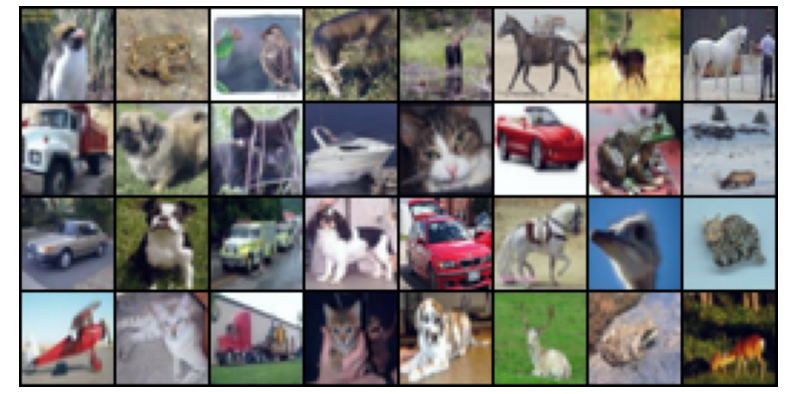

In [ ]:
## Make grid out of visualized base images for contemplating about the learned features at intermediate layer

G2 = vutils.make_grid(img_base, nrow=8, normalize=True, padding=1).permute(1,2,0).numpy()
plt.figure(figsize=(14,7))
plt.imshow(G2)
plt.axis('equal')
plt.axis('off')
plt.show()

### 1g) Use GradCAM algorithm to visualize the saliency maps of your trained model at the same intermediate layer
*   Install pytorch grad cam package if needed (https://github.com/jacobgil/pytorch-grad-cam)
*   Complete the following code that visualizes GradCAM heatmaps on an input image from your model
*   Try on several input images / classes. 
*   Write a small description commenting on the visualized heatmaps. 

In [ ]:
# Install pytorch grad cam package
! pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=bb66074354855d50f4eb6558a384dfd0678f5981936d78fe669b70af98c5632f
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [ ]:
# Importing data for using a random image as input in the GRAD-CAM implementation
transform_train1 = transforms.Compose([
    transforms.ToTensor()
])

batch_size=64
trainset1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train1)
train_dataloader1 = torch.utils.data.DataLoader(trainset1, batch_size=batch_size , shuffle=True)

Files already downloaded and verified


In [ ]:
# Importing data for using dataloader for a random image

index, image_label = next(enumerate(train_dataloader1))
image, label = image_label

from random import randint

num = randint(0, len(label)-1)
rgb_img = image[num]

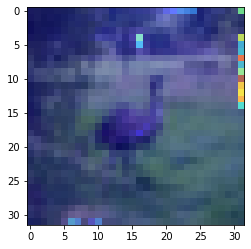

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

use_cuda = False

# *****START CODE
model = ConvNet().to(device)

if device == 'cuda':
  model.load_state_dict(torch.load(save_folder + '/model_8.pt'))
else:
  model.load_state_dict(torch.load(save_folder + '/model_8.pt',map_location=torch.device('cpu')))

#  Get your intermediate layer
target_layers = [model.l1conv]

input_tensor = torch.from_numpy(np.array(rgb_img,np.float32)).unsqueeze(0).to(device)

# Note: input_tensor can be a batch tensor with several images!
target_category = [ClassifierOutputTarget(7)]
# *****END CODE

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=target_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(np.array(rgb_img.permute(1,2,0),np.float32), grayscale_cam, use_rgb=True)

# Plot figure
plt.figure()
plt.imshow(visualization)


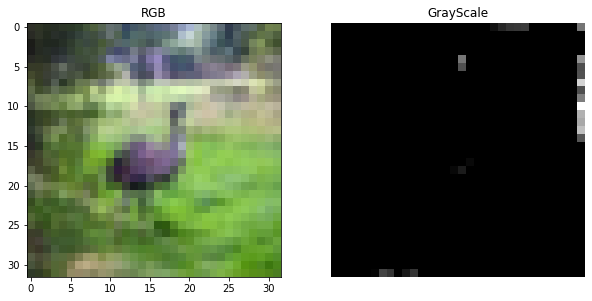

In [ ]:
# Figures showing base and grayscale_cam images

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
ax1.imshow(rgb_img.permute(1,2,0))
ax1.set_title('RGB');

ax2.imshow(grayscale_cam, cmap='gray')
ax2.set_title('GrayScale')
ax2.set_axis_off()

## Question 2 - Train on geometrical shapes

In [ ]:
# Solution not found

#Question 3
Answer these generic questions:

### **3a)** What is a metric? What is a loss? What is the difference between both?


Metrics and loss functions serve distinct yet complementary roles in evaluating and training models. A metric is a quantitative measure of a model's performance on a specific task, such as image classification accuracy on a test set. Conversely, a loss function quantifies the discrepancy between a model's predicted output and the true output, with the goal of training the model to minimize this loss. For example, in the context of image classification, the cross-entropy loss function compares the predicted class probabilities with the true labels and assigns a penalty for incorrect predictions. Through minimizing the average cross-entropy loss over the training set, the model is guided towards output that more closely aligns with the desired output.


### **3b)** Why deep learning models are difficult to understand even on a particular prediction?





Your answer:

Below listed are are a few reasons for why deep learning models are difficult to understand. 

1. Complexity: DL models are complex and highly non-linear systems. This complexity makes them difficult to understand even on a particular prediction because there are many layers of computations and interactions between different neurons that contribute to the final output. Additionally, the internal representations learned by the model may not align with human intuition or concepts, making it difficult to understand how the model arrived at its prediction.

2. High dimentionality: Not only do DL models usually take in a large number of input features, the number of parameters configured internally in the networks make it tough to understand. 
3. Internal Representations: The internal representations learned by the model may not align with intuition or concepts, making it difficult to understand how the model arrived at its prediction.
4. Regularization techniques : Regularization techniques such as dropout and batch normalization are used to prevent overfitting, which can make it harder to understand the model's behavior.







### 3c) What is "out of domain data"?

Out-of-domain data refers to data that is not representative of the distribution of the data that the model was trained on. It is important to consider the performance of a model on out-of-domain data, as it can indicate how well the model generalizes to new, unseen data. A model that is trained on a specific distribution of data, such as a dataset of images of cats, might perform well when presented with new images of cats, but it might not perform as well when presented with images of dogs or other animals that were not present in the training data. Vis a viz the model is being presented with data that is not representative of the distribution it was trained on. Out of domain data can also be referred to as unseen data or novel data, that haven't been seen before during the training phase. Out-of-domain data is important to consider because it can indicate how well a model generalizes to new, unseen data, and can help identify potential biases in the training data.





### 3d) Name five tasks where Deep Learning models are the state-of-the-art:
For example: Folding proteins in Biology

Your answer:

 Following are a few examples of applications of deep learning:

1. Autonomous driving: With the onset of deep learning, cars driving themselves have become a possibility. 

2. Speech to text: NLP methods have enabled crisp speech to text conversions.

3. Deep Fakes: Deep fakes enable person in an existing image or video to be replaced with someone else's likeness. 

4. Image generation: GANs and other methods have enabled useras to generate new unseen images from text descriptions.

5. Chatbots and virtual assistants: Real time generated responses without human intervention has been made possible by DL developments.


3e) What is an “activation function” and what is it used for in Deep Learning models?

Your answer:
An activation function is a mathematical function that is applied to the output of a neuron in a neural network. Its purpose is to introduce non-linearity into the output of the neuron, allowing the neural network to learn a wider range of functions and represent more complex models. Common activation functions include sigmoid, ReLU (rectified linear unit), leaky RELU and tanh (hyperbolic tangent). In deep learning models, activation functions are used to introduce non-linearity into the neural network, allowing the model to learn more complex representations of the input data.